# Simulation Setup

# Univariate sTTH Residual

Fitted Parameters for Y1 (psi, omega, a, nu, h): [ 4.12815224  3.80914367 11.55501297  4.09918692  0.05133724]
Epoch 10/500, Loss: 209509.0000
Epoch 20/500, Loss: 111525.2500
Epoch 30/500, Loss: 70073.6484
Epoch 40/500, Loss: 49437.9023
Epoch 50/500, Loss: 34374.0625
Epoch 60/500, Loss: 25488.8359
Epoch 70/500, Loss: 19301.3750
Epoch 80/500, Loss: 16069.2939
Epoch 90/500, Loss: 14690.3906
Epoch 100/500, Loss: 14011.8799
Epoch 110/500, Loss: 13478.5459
Epoch 120/500, Loss: 12962.7002
Epoch 130/500, Loss: 12520.3916
Epoch 140/500, Loss: 12123.0840
Epoch 150/500, Loss: 11754.6670
Epoch 160/500, Loss: 11395.7480
Epoch 170/500, Loss: 11056.6895
Epoch 180/500, Loss: 10736.4170
Epoch 190/500, Loss: 10427.5312
Epoch 200/500, Loss: 10135.8037
Epoch 210/500, Loss: 9868.1162
Epoch 220/500, Loss: 9615.7598
Epoch 230/500, Loss: 9385.8066
Epoch 240/500, Loss: 9172.0566
Epoch 250/500, Loss: 8979.2822
Epoch 260/500, Loss: 8803.2812
Epoch 270/500, Loss: 8641.7646
Epoch 280/500, Loss: 8492.6777
Epoch 29

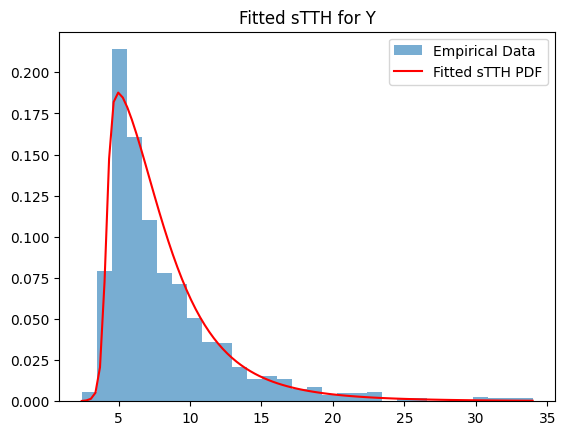

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.special import lambertw
from scipy.stats import t

# Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sSTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sSTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant (adjust for higher acceptance rate)
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

epsilon_1 = simulate_ssth(n, psi=5, omega=1, a= 4, nu=5, h=10)

# Simulate response variables
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1

X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = np.column_stack((Y1))

import numpy as np
from scipy.stats import t
from scipy.special import lambertw

# PDF of the sTTH distribution
def sTTH_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    W0 = lambertw(h * y_scaled**2).real
    w = np.exp(-0.5 * W0)
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    pdf = (2 / omega) * t_pdf * t_cdf * jacobian
    return pdf
def log_likelihood(params, y):
    psi, omega, a, nu, h = params
    # Ensure omega > 0 and nu > 0 for valid parameters
    if omega <= 0 or nu <= 0:
        return np.inf  # Return a large value to penalize invalid parameters

    # Calculate the log-likelihood
    pdf_values = sTTH_pdf(y, psi, omega, a, nu, h)
    # Avoid log(0) or negative likelihoods
    if np.any(pdf_values <= 0):
        return np.inf
    log_likelihood_value = -np.sum(np.log(pdf_values))
    return log_likelihood_value

from scipy.optimize import minimize

# Initial guess for parameters
initial_params = [1, 1, 1, 2, 0.1]  # psi, omega, a, nu, h

# Fit sTTH to Y1
result_Y1 = minimize(log_likelihood, initial_params, args=(Y1,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Extract fitted parameters
params_Y1 = result_Y1.x

print("Fitted Parameters for Y1 (psi, omega, a, nu, h):", params_Y1)
# print("Fitted Parameters for Y2 (psi, omega, a, nu, h):", params_Y2)
import matplotlib.pyplot as plt

# Evaluate the fitted PDF for Y1
y_vals = np.linspace(min(Y1), max(Y1), 100)
fitted_pdf_Y1 = sTTH_pdf(y_vals, *params_Y1)

# Plot histogram and fitted PDF
plt.hist(Y1, bins=30, density=True, alpha=0.6, label='Empirical Data')
plt.plot(y_vals, fitted_pdf_Y1, label='Fitted sTTH PDF', color='red')
plt.title('Fitted sTTH for Y')
plt.legend()
plt.savefig("marginal_sTTH.pdf")

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        """
        Custom loss function based on provided parameters
        :param nu: Degrees of freedom parameter
        :param omega: Scale parameter
        :param a: Shape parameter
        """
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            norm.cdf((self.a * residuals / self.omega).detach().numpy()), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Train and evaluate the model for a specific target (e.g., Y1 or Y2)
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test, nu, omega, a, epochs=500, lr=0.01):
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]
    hidden_size = 32

    # Initialize the model, loss, and optimizer
    msnn_model = MSNN(input_size, hidden_size, output_size)
    custom_loss_fn = CustomLoss(nu, omega, a)
    optimizer = torch.optim.Adam(msnn_model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        msnn_model.train()
        optimizer.zero_grad()
        predictions = msnn_model(X_train_tensor)
        loss = custom_loss_fn(predictions, Y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Evaluate MSE on train and test sets
    msnn_model.eval()
    with torch.no_grad():
        train_predictions = msnn_model(X_train_tensor).numpy()
        test_predictions = msnn_model(X_test_tensor).numpy()
        train_mse = np.mean((train_predictions - Y_train) ** 2)
        test_mse = np.mean((test_predictions - Y_test) ** 2)

    return train_mse, test_mse
# Example extracted parameters (replace with actual estimates from fitting)
omega_1, a_1, nu_1 = params_Y1[1],params_Y1[2],params_Y1[3]  # Parameters for Y1
# omega_2, a_2, nu_2 = params_Y2[1],params_Y2[2],params_Y2[3]  # Parameters for Y2
from sklearn.model_selection import train_test_split
# Ensure Y is a 2D array
Y = Y.reshape(-1, 1)  # Reshape to (1000, 1)

# Split data for Y1
X_train_Y1, X_test_Y1, Y_train_Y1, Y_test_Y1 = train_test_split(X, Y, test_size=0.3, random_state=42)
train_mse_Y1, test_mse_Y1 = train_and_evaluate_model(X_train_Y1, Y_train_Y1, X_test_Y1, Y_test_Y1, nu_1, omega_1, a_1)

print(f"Y1 - Train MSE: {train_mse_Y1:.4f}, Test MSE: {test_mse_Y1:.4f}")

msnn_train_mse = train_mse_Y1
msnn_test_mse = test_mse_Y1

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

from sklearn.kernel_ridge import KernelRidge
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s


# Define SDNN for Multivariate Outputs
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# MSNN Training
input_size = X_train.shape[1]
hidden_size = 32
output_size = 1  # Two outputs for Y1 and Y2

# msnn_model = MSNN(input_size, hidden_size, output_size)

loss_fn_sdnn = nn.MSELoss()

epochs = 100

# SDNN Training
sdnn_model = SDNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(sdnn_model.parameters(), lr=0.01)

for epoch in range(epochs):
    sdnn_model.train()
    optimizer.zero_grad()
    predictions = sdnn_model(X_train_tensor)
    loss = loss_fn_sdnn(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()

# Kernel Regression for Y
kr_model_Y1 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
# kr_model_Y2 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model_Y1.fit(X_train, Y_train[:, 0])
# kr_model_Y2.fit(X_train, Y_train[:, 1])

# OLS for Y
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
ols_model_Y1 = sm.OLS(Y_train[:, 0], X_train_sm).fit()
# ols_model_Y2 = sm.OLS(Y_train[:, 1], X_train_sm).fit()

# Evaluate on Training Set
with torch.no_grad():
    sdnn_train_pred = sdnn_model(X_train_tensor).numpy()
    sdnn_train_mse = mean_squared_error(Y_train, sdnn_train_pred)


kr_train_pred_Y1 = kr_model_Y1.predict(X_train)
# kr_train_pred_Y2 = kr_model_Y2.predict(X_train)
kr_train_mse = mean_squared_error(Y_train[:, 0], kr_train_pred_Y1)

ols_train_pred_Y1 = ols_model_Y1.predict(X_train_sm)
# ols_train_pred_Y2 = ols_model_Y2.predict(X_train_sm)
ols_train_mse = mean_squared_error(Y_train[:, 0], ols_train_pred_Y1)

# Evaluate on Test Set
with torch.no_grad():
    sdnn_test_pred = sdnn_model(X_test_tensor).numpy()
    sdnn_test_mse = mean_squared_error(Y_test, sdnn_test_pred)

# rf_test_pred = rf_model.predict(X_test)
# rf_test_mse = mean_squared_error(Y_test, rf_test_pred)

kr_test_pred_Y1 = kr_model_Y1.predict(X_test)
# kr_test_pred_Y2 = kr_model_Y2.predict(X_test)
kr_test_mse = mean_squared_error(Y_test[:, 0], kr_test_pred_Y1)

ols_test_pred_Y1 = ols_model_Y1.predict(X_test_sm)
# ols_test_pred_Y2 = ols_model_Y2.predict(X_test_sm)
ols_test_mse = mean_squared_error(Y_test[:, 0], ols_test_pred_Y1)

# GAM for Y
gam_Y1 = LinearGAM(s(0, lam=1e6) + s(1, lam=1e6) + s(2, lam=1e6) + s(3, lam=1e6)
 + s(4, lam=1e6) + s(5, lam=1e6))
gam_Y1.fit(X_train, Y_train[:, 0])

gam_train_pred_Y1 = gam_Y1.predict(X_train)
gam_train_mse = mean_squared_error(Y_train[:, 0], gam_train_pred_Y1)

gam_test_pred_Y1 = gam_Y1.predict(X_test)
gam_test_mse = mean_squared_error(Y_test[:, 0], gam_test_pred_Y1)

# Print Results
print("\nModel Performance Comparison (Training Set):")
print(f"MSNN Train MSE: {msnn_train_mse:.4f}")
print(f"SDNN Train MSE: {sdnn_train_mse:.4f}")
print(f"Kernel Regression Train MSE: {kr_train_mse:.4f}")
print(f"OLS Train MSE: {ols_train_mse:.4f}")
print(f"GAM Train MSE: {gam_train_mse:.4f}")

print("\nModel Performance Comparison (Test Set):")
print(f"MSNN Test MSE: {msnn_test_mse:.4f}")
print(f"SDNN Test MSE: {sdnn_test_mse:.4f}")
print(f"Kernel Regression Test MSE: {kr_test_mse:.4f}")
print(f"OLS Test MSE: {ols_test_mse:.4f}")
print(f"GAM Test MSE: {gam_test_mse:.4f}")

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f777187b62c780b5e0d52c14cfe13e93c2ff5663799611b1164a8b38a7d76fc0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install shap

# Consistancy of MSNN

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to train and evaluate MSNN for varying n and hidden layer nodes
def validate_consistency(n_values, hidden_nodes_values, epochs=500, lr=0.01):
    results = []

    for n in n_values:
        # Simulate dataset for current n
        Z1 = np.random.uniform(0, 5, n)
        Z2 = np.random.normal(0, 1, n)
        Z3 = np.random.binomial(10, 0.5, n)
        Z4 = np.random.binomial(1, 0.4, n)
        Z5 = np.random.binomial(1, 0.5, n)
        Z6 = np.random.binomial(1, 0.6, n)
        epsilon_1 = simulate_ssth(n, psi=5, omega=1, a=4, nu=5, h=10)
        Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1
        X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
        Y = Y1.reshape(-1, 1)

        # Split data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

        # Iterate over different hidden layer nodes
        for hidden_nodes in hidden_nodes_values:
            # Train and evaluate MSNN
            train_mse, test_mse = train_and_evaluate_model(
                X_train, Y_train, X_test, Y_test,
                nu=nu_1, omega=omega_1, a=a_1,
                epochs=epochs, lr=lr
            )

            # Store results
            results.append({
                "n": n,
                "hidden_nodes": hidden_nodes,
                "train_mse": train_mse,
                "test_mse": test_mse
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define ranges for n and hidden layer nodes
n_values = [100, 500, 1000, 5000]
hidden_nodes_values = [8, 16, 32, 64]

# Validate consistency
results_df = validate_consistency(n_values, hidden_nodes_values)

Epoch 10/500, Loss: 5998.0562
Epoch 20/500, Loss: 3328.1470
Epoch 30/500, Loss: 3484.8071
Epoch 40/500, Loss: 2871.8989
Epoch 50/500, Loss: 2436.9470
Epoch 60/500, Loss: 2187.5310
Epoch 70/500, Loss: 2005.0712
Epoch 80/500, Loss: 1854.9160
Epoch 90/500, Loss: 1721.7174
Epoch 100/500, Loss: 1599.2122
Epoch 110/500, Loss: 1487.1042
Epoch 120/500, Loss: 1388.2135
Epoch 130/500, Loss: 1297.0929
Epoch 140/500, Loss: 1215.8356
Epoch 150/500, Loss: 1124.3682
Epoch 160/500, Loss: 1037.8336
Epoch 170/500, Loss: 966.4442
Epoch 180/500, Loss: 897.2164
Epoch 190/500, Loss: 830.2164
Epoch 200/500, Loss: 765.2318
Epoch 210/500, Loss: 694.7240
Epoch 220/500, Loss: 628.3284
Epoch 230/500, Loss: 566.7260
Epoch 240/500, Loss: 514.2634
Epoch 250/500, Loss: 470.1297
Epoch 260/500, Loss: 434.8821
Epoch 270/500, Loss: 405.0028
Epoch 280/500, Loss: 379.4422
Epoch 290/500, Loss: 359.2726
Epoch 300/500, Loss: 342.7008
Epoch 310/500, Loss: 329.7541
Epoch 320/500, Loss: 318.5929
Epoch 330/500, Loss: 302.2458
Epo

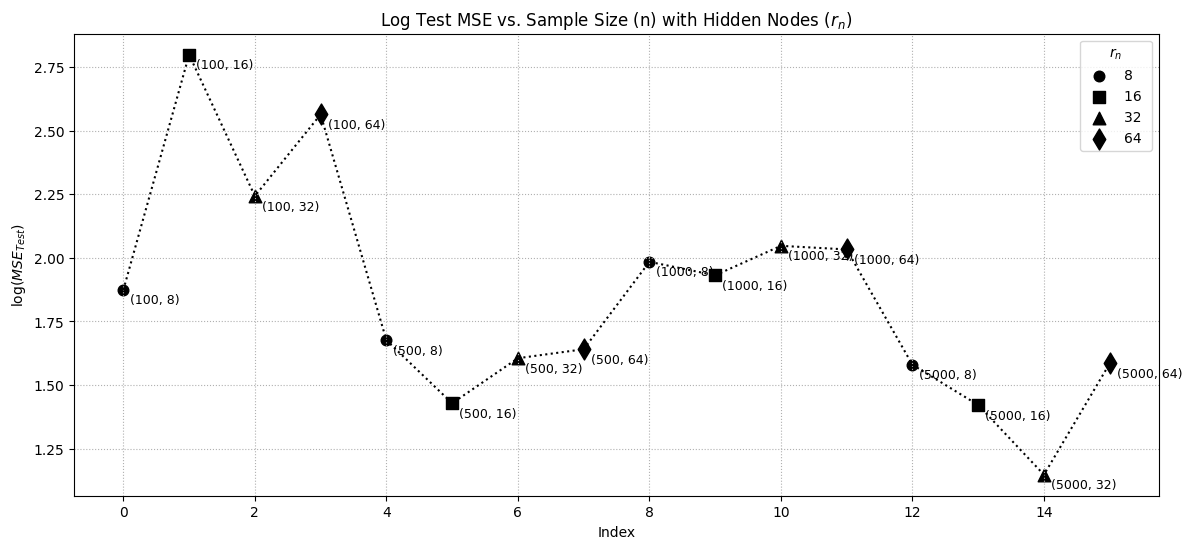

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from the dataframe
n = results_df["n"]
hidden_nodes = results_df["hidden_nodes"]
test_mse = np.log(results_df["test_mse"])

# Define a mapping of hidden nodes to marker styles
hidden_node_markers = {8: 'o', 16: 's', 32: '^', 64: 'd'}  # Circle, square, triangle, diamond

# Create scatter plot with varying point size and different markers for hidden nodes
plt.figure(figsize=(14, 6))

# Plot points with different markers and join them with a dotted line
for i in range(len(n)):
    plt.scatter(i, test_mse.iloc[i], s=50 + hidden_nodes.iloc[i],
                marker=hidden_node_markers[hidden_nodes.iloc[i]], color='black', label=f"{hidden_nodes.iloc[i]} " if f"{hidden_nodes.iloc[i]} " not in plt.gca().get_legend_handles_labels()[1] else "")

# Connect the points with a dotted line
plt.plot(range(len(test_mse)), test_mse, linestyle='dotted', color='black')

# Add annotations (n, r_n) for each point
for i in range(len(n)):
    plt.annotate(f"({n.iloc[i]}, {hidden_nodes.iloc[i]})", (i, test_mse.iloc[i]), fontsize=9, xytext=(5, -10), textcoords='offset points')

# Add legend
plt.legend(title="$r_n$", loc="best")

# Labels and title
plt.xlabel("Index")
plt.ylabel("$\log(MSE_{Test})$")
plt.title("Log Test MSE vs. Sample Size (n) with Hidden Nodes ($r_n$)")

# Display the plot
plt.grid(True, linestyle='dotted')
plt.savefig('consist_skew_msnn.pdf')
# plt.show()


In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


# Bivariate Independent Skewed Residuals

In [ ]:
!pip install copulas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 1.8 MB/s eta 0:00:00


Fitted Parameters for Y1 (psi, omega, a, nu, h): [7.89030655e-02 2.19252696e+00 3.49800709e+01 1.54962948e+00
 8.99619283e-03]
Fitted Parameters for Y2 (psi, omega, a, nu, h): [8.58502006e-02 5.98137403e+00 1.52027447e+02 1.88023324e+02
 1.13633826e-01]
Epoch 10/500, Loss: 248264.7344
Epoch 20/500, Loss: 206705.6875
Epoch 30/500, Loss: 161562.9844
Epoch 40/500, Loss: 116548.8750
Epoch 50/500, Loss: 77438.5938
Epoch 60/500, Loss: 53572.0977
Epoch 70/500, Loss: 41905.0781
Epoch 80/500, Loss: 35637.9922
Epoch 90/500, Loss: 31453.5586
Epoch 100/500, Loss: 27966.9961
Epoch 110/500, Loss: 24652.5469
Epoch 120/500, Loss: 21310.9883
Epoch 130/500, Loss: 18123.4707
Epoch 140/500, Loss: 15239.3477
Epoch 150/500, Loss: 12799.8018
Epoch 160/500, Loss: 10877.2871
Epoch 170/500, Loss: 9414.7236
Epoch 180/500, Loss: 8309.2715
Epoch 190/500, Loss: 7451.4355
Epoch 200/500, Loss: 6755.8008
Epoch 210/500, Loss: 6179.6445
Epoch 220/500, Loss: 5688.1011
Epoch 230/500, Loss: 5264.9121
Epoch 240/500, Loss: 4

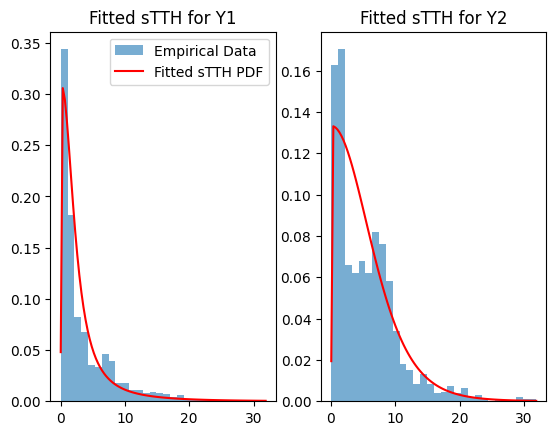

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.special import lambertw
from scipy.stats import t

# Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sSTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sSTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant (adjust for higher acceptance rate)
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

epsilon_1 = simulate_ssth(n, psi=4, omega=1, a=2, nu=2, h=0.3)
epsilon_2 = simulate_ssth(n, psi=2, omega=2, a=4, nu=3, h=0.5)

# Transform marginals to [0, 1] using empirical CDF
def to_uniform(data):
    from scipy.stats import rankdata
    ranks = rankdata(data, method='average')
    return (ranks - 1) / (len(data) - 1)

epsilon_1_uniform = to_uniform(epsilon_1)
epsilon_2_uniform = to_uniform(epsilon_2)

# Simulate response variables
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1_uniform
Y2 = Z1 * Z2**2 + Z3 * Z4 + Z5 * Z6 + epsilon_2_uniform
X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = np.column_stack((Y1, Y2))

import numpy as np
from scipy.stats import t
from scipy.special import lambertw

# PDF of the sTTH distribution
def sTTH_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    W0 = lambertw(h * y_scaled**2).real
    w = np.exp(-0.5 * W0)
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    pdf = (2 / omega) * t_pdf * t_cdf * jacobian
    return pdf
def log_likelihood(params, y):
    psi, omega, a, nu, h = params
    # Ensure omega > 0 and nu > 0 for valid parameters
    if omega <= 0 or nu <= 0:
        return np.inf  # Return a large value to penalize invalid parameters

    # Calculate the log-likelihood
    pdf_values = sTTH_pdf(y, psi, omega, a, nu, h)
    # Avoid log(0) or negative likelihoods
    if np.any(pdf_values <= 0):
        return np.inf
    log_likelihood_value = -np.sum(np.log(pdf_values))
    return log_likelihood_value
from scipy.optimize import minimize

# Initial guess for parameters
initial_params = [1, 1, 1, 2, 0.1]  # psi, omega, a, nu, h

# Fit sTTH to Y1
result_Y1 = minimize(log_likelihood, initial_params, args=(Y1,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Fit sTTH to Y2
result_Y2 = minimize(log_likelihood, initial_params, args=(Y2,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Extract fitted parameters
params_Y1 = result_Y1.x
params_Y2 = result_Y2.x

print("Fitted Parameters for Y1 (psi, omega, a, nu, h):", params_Y1)
print("Fitted Parameters for Y2 (psi, omega, a, nu, h):", params_Y2)
import matplotlib.pyplot as plt

# Evaluate the fitted PDF for Y1
y1_vals = np.linspace(min(Y1), max(Y1), 100)
fitted_pdf_Y1 = sTTH_pdf(y1_vals, *params_Y1)

y2_vals = np.linspace(min(Y2), max(Y2), 100)
fitted_pdf_Y2 = sTTH_pdf(y2_vals, *params_Y2)

# Plot histogram and fitted PDF
plt.subplot(1, 2, 1)
plt.hist(Y1, bins=30, density=True, alpha=0.6, label='Empirical Data')
plt.plot(y1_vals, fitted_pdf_Y1, label='Fitted sTTH PDF', color='red')
plt.title('Fitted sTTH for Y1')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(Y2, bins=30, density=True, alpha=0.6, label='Empirical Data')
plt.plot(y2_vals, fitted_pdf_Y2, label='Fitted sTTH PDF', color='red')
plt.title('Fitted sTTH for Y2')
plt.savefig("bivariate_sTTH.pdf")

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        """
        Custom loss function based on provided parameters
        :param nu: Degrees of freedom parameter
        :param omega: Scale parameter
        :param a: Shape parameter
        """
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            norm.cdf((self.a * residuals / self.omega).detach().numpy()), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Train and evaluate the model for a specific target (e.g., Y1 or Y2)
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test, nu, omega, a, epochs=500, lr=0.01):
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]
    hidden_size = 32

    # Initialize the model, loss, and optimizer
    msnn_model = MSNN(input_size, hidden_size, output_size)
    custom_loss_fn = CustomLoss(nu, omega, a)
    optimizer = torch.optim.Adam(msnn_model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        msnn_model.train()
        optimizer.zero_grad()
        predictions = msnn_model(X_train_tensor)
        loss = custom_loss_fn(predictions, Y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Evaluate MSE on train and test sets
    msnn_model.eval()
    with torch.no_grad():
        train_predictions = msnn_model(X_train_tensor).numpy()
        test_predictions = msnn_model(X_test_tensor).numpy()
        train_mse = np.mean((train_predictions - Y_train) ** 2)
        test_mse = np.mean((test_predictions - Y_test) ** 2)

    return train_mse, test_mse
# Example extracted parameters (replace with actual estimates from fitting)
omega_1, a_1, nu_1 = params_Y1[1],params_Y1[2],params_Y1[3]  # Parameters for Y1
omega_2, a_2, nu_2 = params_Y2[1],params_Y2[2],params_Y2[3]  # Parameters for Y2
from sklearn.model_selection import train_test_split

# Split data for Y1
X_train_Y1, X_test_Y1, Y_train_Y1, Y_test_Y1 = train_test_split(X, Y[:, 0:1], test_size=0.3, random_state=42)
train_mse_Y1, test_mse_Y1 = train_and_evaluate_model(X_train_Y1, Y_train_Y1, X_test_Y1, Y_test_Y1, nu_1, omega_1, a_1)

# Split data for Y2
X_train_Y2, X_test_Y2, Y_train_Y2, Y_test_Y2 = train_test_split(X, Y[:, 1:2], test_size=0.3, random_state=42)
train_mse_Y2, test_mse_Y2 = train_and_evaluate_model(X_train_Y2, Y_train_Y2, X_test_Y2, Y_test_Y2, nu_2, omega_2, a_2)

# Print results
print(f"Y1 - Train MSE: {train_mse_Y1:.4f}, Test MSE: {test_mse_Y1:.4f}")
print(f"Y2 - Train MSE: {train_mse_Y2:.4f}, Test MSE: {test_mse_Y2:.4f}")

msnn_train_mse = train_mse_Y1 + train_mse_Y2
msnn_test_mse = test_mse_Y1 + test_mse_Y2

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)


# Define SDNN for Multivariate Outputs
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# MSNN Training
input_size = X_train.shape[1]
hidden_size = 32
output_size = 2  # Two outputs for Y1 and Y2

# msnn_model = MSNN(input_size, hidden_size, output_size)

loss_fn_sdnn = nn.MSELoss()

epochs = 100

# SDNN Training
sdnn_model = SDNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(sdnn_model.parameters(), lr=0.01)

for epoch in range(epochs):
    sdnn_model.train()
    optimizer.zero_grad()
    predictions = sdnn_model(X_train_tensor)
    loss = loss_fn_sdnn(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()

# # Random Forest for Y
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, Y_train)

# Kernel Regression for Y
kr_model_Y1 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model_Y2 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model_Y1.fit(X_train, Y_train[:, 0])
kr_model_Y2.fit(X_train, Y_train[:, 1])

# OLS for Y
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
ols_model_Y1 = sm.OLS(Y_train[:, 0], X_train_sm).fit()
ols_model_Y2 = sm.OLS(Y_train[:, 1], X_train_sm).fit()

# Evaluate on Training Set
with torch.no_grad():
    sdnn_train_pred = sdnn_model(X_train_tensor).numpy()
    sdnn_train_mse = mean_squared_error(Y_train, sdnn_train_pred)


kr_train_pred_Y1 = kr_model_Y1.predict(X_train)
kr_train_pred_Y2 = kr_model_Y2.predict(X_train)
kr_train_mse = mean_squared_error(Y_train[:, 0], kr_train_pred_Y1) + mean_squared_error(Y_train[:, 1], kr_train_pred_Y2)

ols_train_pred_Y1 = ols_model_Y1.predict(X_train_sm)
ols_train_pred_Y2 = ols_model_Y2.predict(X_train_sm)
ols_train_mse = mean_squared_error(Y_train[:, 0], ols_train_pred_Y1) + mean_squared_error(Y_train[:, 1], ols_train_pred_Y2)

# Evaluate on Test Set
with torch.no_grad():
    sdnn_test_pred = sdnn_model(X_test_tensor).numpy()
    sdnn_test_mse = mean_squared_error(Y_test, sdnn_test_pred)

# rf_test_pred = rf_model.predict(X_test)
# rf_test_mse = mean_squared_error(Y_test, rf_test_pred)

kr_test_pred_Y1 = kr_model_Y1.predict(X_test)
kr_test_pred_Y2 = kr_model_Y2.predict(X_test)
kr_test_mse = mean_squared_error(Y_test[:, 0], kr_test_pred_Y1) + mean_squared_error(Y_test[:, 1], kr_test_pred_Y2)

ols_test_pred_Y1 = ols_model_Y1.predict(X_test_sm)
ols_test_pred_Y2 = ols_model_Y2.predict(X_test_sm)
ols_test_mse = mean_squared_error(Y_test[:, 0], ols_test_pred_Y1) + mean_squared_error(Y_test[:, 1], ols_test_pred_Y2)

# GAM for Y
gam_Y1 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam_Y1.fit(X_train, Y_train[:, 0])

gam_Y2 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam_Y2.fit(X_train, Y_train[:, 1])

gam_train_pred_Y1 = gam_Y1.predict(X_train)
gam_train_pred_Y2 = gam_Y2.predict(X_train)
gam_train_mse = mean_squared_error(Y_train[:, 0], gam_train_pred_Y1) + mean_squared_error(Y_train[:, 1], gam_train_pred_Y2)

gam_test_pred_Y1 = gam_Y1.predict(X_test)
gam_test_pred_Y2 = gam_Y2.predict(X_test)
gam_test_mse = mean_squared_error(Y_test[:, 0], gam_test_pred_Y1) + mean_squared_error(Y_test[:, 1], gam_test_pred_Y2)

# Print Results
print("\nModel Performance Comparison (Training Set):")
print(f"MSNN Train MSE: {msnn_train_mse:.4f}")
print(f"SDNN Train MSE: {sdnn_train_mse:.4f}")
# print(f"Random Forest Train MSE: {rf_train_mse:.4f}")
print(f"Kernel Regression Train MSE: {kr_train_mse:.4f}")
print(f"OLS Train MSE: {ols_train_mse:.4f}")
print(f"GAM Train MSE: {gam_train_mse:.4f}")

print("\nModel Performance Comparison (Test Set):")
print(f"MSNN Test MSE: {msnn_test_mse:.4f}")
print(f"SDNN Test MSE: {sdnn_test_mse:.4f}")
# print(f"Random Forest Test MSE: {rf_test_mse:.4f}")
print(f"Kernel Regression Test MSE: {kr_test_mse:.4f}")
print(f"OLS Test MSE: {ols_test_mse:.4f}")
print(f"GAM Test MSE: {gam_test_mse:.4f}")

# Robustness

Shape of X: (1000, 6)
Shape of Y: (1000, 2)
Fitted Parameters for Y1 (psi, omega, a, nu, h): [3.90579413 4.85583599 3.81150182 9.87755428 0.08921498]
Fitted Parameters for Y2 (psi, omega, a, nu, h): [-2.02325304e-01  6.75975955e+00  1.77046431e+00  1.14364188e+02
  1.11970274e-01]
Epoch 10/500, Loss: 122588.1094
Epoch 20/500, Loss: 72476.1406
Epoch 30/500, Loss: 45584.5898
Epoch 40/500, Loss: 34746.4453
Epoch 50/500, Loss: 29216.3906
Epoch 60/500, Loss: 24376.7930
Epoch 70/500, Loss: 19879.2266
Epoch 80/500, Loss: 15853.1865
Epoch 90/500, Loss: 13041.9375
Epoch 100/500, Loss: 11372.9414
Epoch 110/500, Loss: 10520.7578
Epoch 120/500, Loss: 9986.9824
Epoch 130/500, Loss: 9596.4707
Epoch 140/500, Loss: 9270.1484
Epoch 150/500, Loss: 8959.5156
Epoch 160/500, Loss: 8676.1797
Epoch 170/500, Loss: 8420.9385
Epoch 180/500, Loss: 8179.5630
Epoch 190/500, Loss: 7961.4912
Epoch 200/500, Loss: 7758.2178
Epoch 210/500, Loss: 7570.2817
Epoch 220/500, Loss: 7392.0322
Epoch 230/500, Loss: 7219.9683
Ep

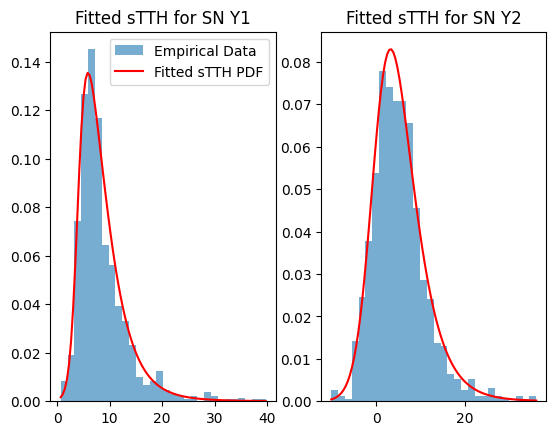

In [ ]:
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.stats import rankdata

# Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Simulate from bivariate skew normal distribution
def simulate_bivariate_skew_normal(n, loc, scale, alpha, correlation):
    """
    Simulate n samples from a bivariate skew normal distribution.
    :param n: Number of samples.
    :param loc: Mean vector of length 2.
    :param scale: Standard deviation vector of length 2.
    :param alpha: Skewness vector of length 2 (as a NumPy array).
    :param correlation: Correlation coefficient between the two variables.
    :return: n x 2 array of simulated samples.
    """
    # Convert alpha to a NumPy array if not already
    alpha = np.array(alpha)

    # Correlation matrix
    cov_matrix = np.array([
        [scale[0]**2, correlation * scale[0] * scale[1]],
        [correlation * scale[0] * scale[1], scale[1]**2]
    ])

    # Generate base samples from multivariate normal
    mvn = multivariate_normal(mean=loc, cov=cov_matrix)
    Z = mvn.rvs(size=n)

    # Apply skewness transformation
    delta = alpha / np.sqrt(1 + alpha**2)  # Delta for each variable
    u = norm.cdf(delta[0] * Z[:, 0] + delta[1] * Z[:, 1])  # Skewing variable
    skewed_samples = Z + np.outer(norm.ppf(u), delta)

    return skewed_samples

# Parameters for the bivariate skew normal
loc = [4, 2]             # Mean vector
scale = [1, 2]           # Standard deviations
alpha = [2, -3]          # Skewness for each variable
correlation = 0.5        # Correlation between variables

# Simulate epsilon_1 and epsilon_2
epsilon_samples = simulate_bivariate_skew_normal(n, loc, scale, alpha, correlation)
epsilon_1, epsilon_2 = epsilon_samples[:, 0], epsilon_samples[:, 1]

# Transform marginals to [0, 1] using empirical CDF
def to_uniform(data):
    ranks = rankdata(data, method='average')
    return (ranks - 1) / (len(data) - 1)

epsilon_1_uniform = to_uniform(epsilon_1)
epsilon_2_uniform = to_uniform(epsilon_2)

# Simulate response variables
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1
Y2 = Z1 * Z2**2 + Z3 * Z4 + Z5 * Z6 + epsilon_2
X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = np.column_stack((Y1, Y2))

# Check dimensions
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

import numpy as np
from scipy.stats import t
from scipy.special import lambertw

# PDF of the sTTH distribution
def sTTH_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    W0 = lambertw(h * y_scaled**2).real
    w = np.exp(-0.5 * W0)
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    pdf = (2 / omega) * t_pdf * t_cdf * jacobian
    return pdf
def log_likelihood(params, y):
    psi, omega, a, nu, h = params
    # Ensure omega > 0 and nu > 0 for valid parameters
    if omega <= 0 or nu <= 0:
        return np.inf  # Return a large value to penalize invalid parameters

    # Calculate the log-likelihood
    pdf_values = sTTH_pdf(y, psi, omega, a, nu, h)
    # Avoid log(0) or negative likelihoods
    if np.any(pdf_values <= 0):
        return np.inf
    log_likelihood_value = -np.sum(np.log(pdf_values))
    return log_likelihood_value
from scipy.optimize import minimize

# Initial guess for parameters
initial_params = [1, 1, 1, 2, 0.1]  # psi, omega, a, nu, h

# Fit sTTH to Y1
result_Y1 = minimize(log_likelihood, initial_params, args=(Y1,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Fit sTTH to Y2
result_Y2 = minimize(log_likelihood, initial_params, args=(Y2,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Extract fitted parameters
params_Y1 = result_Y1.x
params_Y2 = result_Y2.x

print("Fitted Parameters for Y1 (psi, omega, a, nu, h):", params_Y1)
print("Fitted Parameters for Y2 (psi, omega, a, nu, h):", params_Y2)
import matplotlib.pyplot as plt

# Evaluate the fitted PDF for Y1
y1_vals = np.linspace(min(Y1), max(Y1), 100)
y2_vals = np.linspace(min(Y2), max(Y2), 100)


fitted_pdf_Y1 = sTTH_pdf(y1_vals, *params_Y1)
fitted_pdf_Y2 = sTTH_pdf(y2_vals, *params_Y2)

# Plot histogram and fitted PDF
plt.subplot(1, 2, 1)
plt.hist(Y1, bins=30, density=True, alpha=0.6, label='Empirical Data')
plt.plot(y1_vals, fitted_pdf_Y1, label='Fitted sTTH PDF', color='red')
plt.title('Fitted sTTH for SN Y1')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(Y2, bins=30, density=True, alpha=0.6, label='Empirical Data')
plt.plot(y2_vals, fitted_pdf_Y2, label='Fitted sTTH PDF', color='red')
plt.title('Fitted sTTH for SN Y2')
# plt.legend()
plt.savefig("robust.pdf")

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        """
        Custom loss function based on provided parameters
        :param nu: Degrees of freedom parameter
        :param omega: Scale parameter
        :param a: Shape parameter
        """
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            norm.cdf((self.a * residuals / self.omega).detach().numpy()), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Train and evaluate the model for a specific target (e.g., Y1 or Y2)
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test, nu, omega, a, epochs=500, lr=0.01):
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]
    hidden_size = 32

    # Initialize the model, loss, and optimizer
    msnn_model = MSNN(input_size, hidden_size, output_size)
    custom_loss_fn = CustomLoss(nu, omega, a)
    optimizer = torch.optim.Adam(msnn_model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        msnn_model.train()
        optimizer.zero_grad()
        predictions = msnn_model(X_train_tensor)
        loss = custom_loss_fn(predictions, Y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Evaluate MSE on train and test sets
    msnn_model.eval()
    with torch.no_grad():
        train_predictions = msnn_model(X_train_tensor).numpy()
        test_predictions = msnn_model(X_test_tensor).numpy()
        train_mse = np.mean((train_predictions - Y_train) ** 2)
        test_mse = np.mean((test_predictions - Y_test) ** 2)

    return train_mse, test_mse
# Example extracted parameters (replace with actual estimates from fitting)
omega_1, a_1, nu_1 = params_Y1[1],params_Y1[2],params_Y1[3]  # Parameters for Y1
omega_2, a_2, nu_2 = params_Y2[1],params_Y2[2],params_Y2[3]  # Parameters for Y2
from sklearn.model_selection import train_test_split

# Split data for Y1
X_train_Y1, X_test_Y1, Y_train_Y1, Y_test_Y1 = train_test_split(X, Y[:, 0:1], test_size=0.3, random_state=42)
train_mse_Y1, test_mse_Y1 = train_and_evaluate_model(X_train_Y1, Y_train_Y1, X_test_Y1, Y_test_Y1, nu_1, omega_1, a_1)

# Split data for Y2
X_train_Y2, X_test_Y2, Y_train_Y2, Y_test_Y2 = train_test_split(X, Y[:, 1:2], test_size=0.3, random_state=42)
train_mse_Y2, test_mse_Y2 = train_and_evaluate_model(X_train_Y2, Y_train_Y2, X_test_Y2, Y_test_Y2, nu_2, omega_2, a_2)

# Print results
print(f"Y1 - Train MSE: {train_mse_Y1:.4f}, Test MSE: {test_mse_Y1:.4f}")
print(f"Y2 - Train MSE: {train_mse_Y2:.4f}, Test MSE: {test_mse_Y2:.4f}")

msnn_train_mse = train_mse_Y1 + train_mse_Y2
msnn_test_mse = test_mse_Y1 + test_mse_Y2

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)


# Define SDNN for Multivariate Outputs
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# MSNN Training
input_size = X_train.shape[1]
hidden_size = 32
output_size = 2  # Two outputs for Y1 and Y2

# msnn_model = MSNN(input_size, hidden_size, output_size)

loss_fn_sdnn = nn.MSELoss()

epochs = 100

# SDNN Training
sdnn_model = SDNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(sdnn_model.parameters(), lr=0.01)

for epoch in range(epochs):
    sdnn_model.train()
    optimizer.zero_grad()
    predictions = sdnn_model(X_train_tensor)
    loss = loss_fn_sdnn(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()

# # Random Forest for Y
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, Y_train)

# Kernel Regression for Y
kr_model_Y1 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model_Y2 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model_Y1.fit(X_train, Y_train[:, 0])
kr_model_Y2.fit(X_train, Y_train[:, 1])

# OLS for Y
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
ols_model_Y1 = sm.OLS(Y_train[:, 0], X_train_sm).fit()
ols_model_Y2 = sm.OLS(Y_train[:, 1], X_train_sm).fit()

# Evaluate on Training Set
with torch.no_grad():
    sdnn_train_pred = sdnn_model(X_train_tensor).numpy()
    sdnn_train_mse = mean_squared_error(Y_train, sdnn_train_pred)


kr_train_pred_Y1 = kr_model_Y1.predict(X_train)
kr_train_pred_Y2 = kr_model_Y2.predict(X_train)
kr_train_mse = mean_squared_error(Y_train[:, 0], kr_train_pred_Y1) + mean_squared_error(Y_train[:, 1], kr_train_pred_Y2)

ols_train_pred_Y1 = ols_model_Y1.predict(X_train_sm)
ols_train_pred_Y2 = ols_model_Y2.predict(X_train_sm)
ols_train_mse = mean_squared_error(Y_train[:, 0], ols_train_pred_Y1) + mean_squared_error(Y_train[:, 1], ols_train_pred_Y2)

# Evaluate on Test Set
with torch.no_grad():
    sdnn_test_pred = sdnn_model(X_test_tensor).numpy()
    sdnn_test_mse = mean_squared_error(Y_test, sdnn_test_pred)

# rf_test_pred = rf_model.predict(X_test)
# rf_test_mse = mean_squared_error(Y_test, rf_test_pred)

kr_test_pred_Y1 = kr_model_Y1.predict(X_test)
kr_test_pred_Y2 = kr_model_Y2.predict(X_test)
kr_test_mse = mean_squared_error(Y_test[:, 0], kr_test_pred_Y1) + mean_squared_error(Y_test[:, 1], kr_test_pred_Y2)

ols_test_pred_Y1 = ols_model_Y1.predict(X_test_sm)
ols_test_pred_Y2 = ols_model_Y2.predict(X_test_sm)
ols_test_mse = mean_squared_error(Y_test[:, 0], ols_test_pred_Y1) + mean_squared_error(Y_test[:, 1], ols_test_pred_Y2)

# GAM for Y
gam_Y1 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam_Y1.fit(X_train, Y_train[:, 0])

gam_Y2 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam_Y2.fit(X_train, Y_train[:, 1])

gam_train_pred_Y1 = gam_Y1.predict(X_train)
gam_train_pred_Y2 = gam_Y2.predict(X_train)
gam_train_mse = mean_squared_error(Y_train[:, 0], gam_train_pred_Y1) + mean_squared_error(Y_train[:, 1], gam_train_pred_Y2)

gam_test_pred_Y1 = gam_Y1.predict(X_test)
gam_test_pred_Y2 = gam_Y2.predict(X_test)
gam_test_mse = mean_squared_error(Y_test[:, 0], gam_test_pred_Y1) + mean_squared_error(Y_test[:, 1], gam_test_pred_Y2)

# Print Results
print("\nModel Performance Comparison (Training Set):")
print(f"MSNN Train MSE: {msnn_train_mse:.4f}")
print(f"SDNN Train MSE: {sdnn_train_mse:.4f}")
# print(f"Random Forest Train MSE: {rf_train_mse:.4f}")
print(f"Kernel Regression Train MSE: {kr_train_mse:.4f}")
print(f"OLS Train MSE: {ols_train_mse:.4f}")
print(f"GAM Train MSE: {gam_train_mse:.4f}")

print("\nModel Performance Comparison (Test Set):")
print(f"MSNN Test MSE: {msnn_test_mse:.4f}")
print(f"SDNN Test MSE: {sdnn_test_mse:.4f}")
# print(f"Random Forest Test MSE: {rf_test_mse:.4f}")
print(f"Kernel Regression Test MSE: {kr_test_mse:.4f}")
print(f"OLS Test MSE: {ols_test_mse:.4f}")
print(f"GAM Test MSE: {gam_test_mse:.4f}")

# Bivariate Dependent Residuals Using Copula

In [ ]:
!pip install copulas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


Estimated Frank Copula Parameter (theta): -0.18389922397145939
Shape of X_train: (700, 6)
Shape of Y_train: (700, 2)
Fitted Parameters for Y1 (psi, omega, a, nu, h): [2.85961106 5.2718387  5.41253562 6.13417555 0.07043032]
Fitted Parameters for Y2 (psi, omega, a, nu, h): [ 1.51187295  6.42025084 21.74628122  2.40360697  0.02634324]
Epoch 10/500, Loss: 215755.7969
Epoch 20/500, Loss: 130868.0938
Epoch 30/500, Loss: 102296.7344
Epoch 40/500, Loss: 87150.6719
Epoch 50/500, Loss: 77141.2734
Epoch 60/500, Loss: 70126.7188
Epoch 70/500, Loss: 66106.9219
Epoch 80/500, Loss: 64430.5039
Epoch 90/500, Loss: 63373.4414
Epoch 100/500, Loss: 62480.0234
Epoch 110/500, Loss: 60874.7773
Epoch 120/500, Loss: 59466.7188
Epoch 130/500, Loss: 57979.4180
Epoch 140/500, Loss: 56241.4219
Epoch 150/500, Loss: 54462.9062
Epoch 160/500, Loss: 52904.3008
Epoch 170/500, Loss: 51132.4141
Epoch 180/500, Loss: 49252.8047
Epoch 190/500, Loss: 47462.2344
Epoch 200/500, Loss: 46120.8984
Epoch 210/500, Loss: 44719.1445


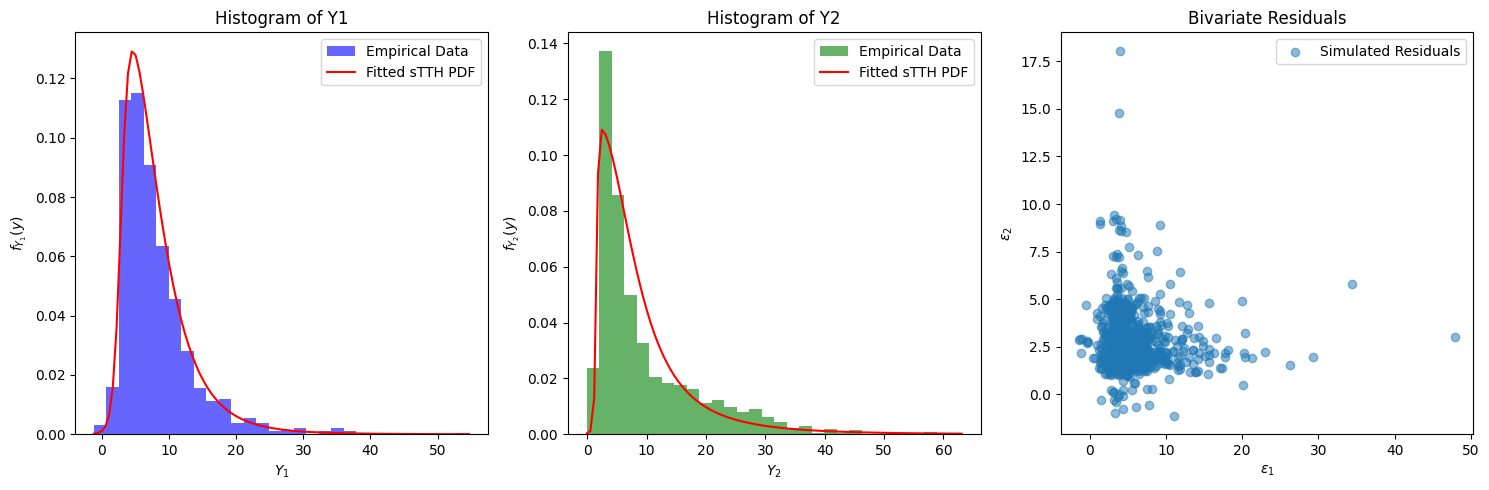

In [ ]:
import numpy as np
from scipy.stats import rankdata, t
from scipy.special import lambertw
from copulas.bivariate import Frank
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.kernel_ridge import KernelRidge
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pygam import LinearGAM, s

# Step 1: Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sTTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sTTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant (adjust for higher acceptance rate)
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

# Step 2: Simulate residuals (\epsilon_1, \epsilon_2)
epsilon_1 = simulate_ssth(n, psi=4, omega=1, a=2, nu=2, h=0.3)
epsilon_2 = simulate_ssth(n, psi=2, omega=2, a=4, nu=3, h=0.5)

# Step 3: Transform residuals to uniform [0, 1]
def to_uniform(data):
    ranks = rankdata(data, method='average')
    return (ranks - 1) / (len(data) - 1)

u1 = to_uniform(epsilon_1)
u2 = to_uniform(epsilon_2)

# Step 4: Fit Frank Copula
frank = Frank()

# Fit the copula using the uniform marginals
frank.fit(np.column_stack((u1, u2)))

# Print the estimated theta
theta = frank.theta
print(f"Estimated Frank Copula Parameter (theta): {theta}")

# Step 5: Simulate bivariate residuals using Frank copula
simulated_u = frank.sample(n)  # Generate bivariate samples

simulated_epsilon_1 = np.percentile(epsilon_1, simulated_u[:, 0] * 100)
simulated_epsilon_2 = np.percentile(epsilon_2, simulated_u[:, 1] * 100)

# Step 6: Construct Y1 and Y2
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + simulated_epsilon_1
Y2 = Z1 * Z2**2 + Z1 * Z3 * Z4 + Z5 * Z6 + simulated_epsilon_2
X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = np.column_stack((Y1, Y2))

# Step 8: Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")

import numpy as np
from scipy.stats import t
from scipy.special import lambertw

# PDF of the sTTH distribution
def sTTH_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    W0 = lambertw(h * y_scaled**2).real
    w = np.exp(-0.5 * W0)
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    pdf = (2 / omega) * t_pdf * t_cdf * jacobian
    return pdf
def log_likelihood(params, y):
    psi, omega, a, nu, h = params
    # Ensure omega > 0 and nu > 0 for valid parameters
    if omega <= 0 or nu <= 0:
        return np.inf  # Return a large value to penalize invalid parameters

    # Calculate the log-likelihood
    pdf_values = sTTH_pdf(y, psi, omega, a, nu, h)
    # Avoid log(0) or negative likelihoods
    if np.any(pdf_values <= 0):
        return np.inf
    log_likelihood_value = -np.sum(np.log(pdf_values))
    return log_likelihood_value
from scipy.optimize import minimize

# Initial guess for parameters
initial_params = [1, 1, 1, 2, 0.1]  # psi, omega, a, nu, h

# Fit sTTH to Y1
result_Y1 = minimize(log_likelihood, initial_params, args=(Y1,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Fit sTTH to Y2
result_Y2 = minimize(log_likelihood, initial_params, args=(Y2,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Extract fitted parameters
params_Y1 = result_Y1.x
params_Y2 = result_Y2.x

print("Fitted Parameters for Y1 (psi, omega, a, nu, h):", params_Y1)
print("Fitted Parameters for Y2 (psi, omega, a, nu, h):", params_Y2)
import matplotlib.pyplot as plt

# Evaluate the fitted PDF for Y1
y1_vals = np.linspace(min(Y1), max(Y1), 100)
fitted_pdf_Y1 = sTTH_pdf(y1_vals, *params_Y1)

y2_vals = np.linspace(min(Y2), max(Y2), 100)
fitted_pdf_Y2 = sTTH_pdf(y2_vals, *params_Y2)

# Step 7: Plot the bivariate residuals and response distributions
plt.figure(figsize=(15, 5))

# Histogram of Y1
plt.subplot(1, 3, 1)
plt.hist(Y1, bins=30, density=True, alpha=0.6, color='blue', label='Empirical Data')
plt.plot(y1_vals, fitted_pdf_Y1, label='Fitted sTTH PDF', color='red')
plt.xlabel(r'$Y_1$')
plt.ylabel(r'$f_{Y_1}(y)$')
plt.title('Histogram of Y1')
plt.legend()

# Histogram of Y2
plt.subplot(1, 3, 2)
plt.hist(Y2, bins=30, density=True, alpha=0.6, color='green', label='Empirical Data')
plt.plot(y2_vals, fitted_pdf_Y2, label='Fitted sTTH PDF', color='red')
plt.xlabel(r'$Y_2$')
plt.ylabel(r'$f_{Y_2}(y)$')
plt.title('Histogram of Y2')
plt.legend()

# Contour plot of residuals
plt.subplot(1, 3, 3)
plt.scatter(simulated_epsilon_1, simulated_epsilon_2, alpha=0.5, label="Simulated Residuals")
plt.title('Bivariate Residuals')
plt.xlabel(r'$\epsilon_1$')
plt.ylabel(r'$\epsilon_2$')
plt.legend()

plt.tight_layout()
plt.savefig("dependent_skewed_residuals.pdf")


import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        """
        Custom loss function based on provided parameters
        :param nu: Degrees of freedom parameter
        :param omega: Scale parameter
        :param a: Shape parameter
        """
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            t.cdf((self.a * residuals / self.omega).detach().numpy(), df=self.nu), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Train and evaluate the model for a specific target (e.g., Y1 or Y2)
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test, nu, omega, a, epochs=500, lr=0.01):
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]
    hidden_size = 32

    # Initialize the model, loss, and optimizer
    msnn_model = MSNN(input_size, hidden_size, output_size)
    custom_loss_fn = CustomLoss(nu, omega, a)
    optimizer = torch.optim.Adam(msnn_model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        msnn_model.train()
        optimizer.zero_grad()
        predictions = msnn_model(X_train_tensor)
        loss = custom_loss_fn(predictions, Y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Evaluate MSE on train and test sets
    msnn_model.eval()
    with torch.no_grad():
        train_predictions = msnn_model(X_train_tensor).numpy()
        test_predictions = msnn_model(X_test_tensor).numpy()
        train_mse = np.mean((train_predictions - Y_train) ** 2)
        test_mse = np.mean((test_predictions - Y_test) ** 2)

    return train_mse, test_mse
# Example extracted parameters (replace with actual estimates from fitting)
omega_1, a_1, nu_1 = params_Y1[1],params_Y1[2],params_Y1[3]  # Parameters for Y1
omega_2, a_2, nu_2 = params_Y2[1],params_Y2[2],params_Y2[3]  # Parameters for Y2
from sklearn.model_selection import train_test_split

# Split data for Y1
X_train_Y1, X_test_Y1, Y_train_Y1, Y_test_Y1 = train_test_split(X, Y[:, 0:1], test_size=0.3, random_state=42)
train_mse_Y1, test_mse_Y1 = train_and_evaluate_model(X_train_Y1, Y_train_Y1, X_test_Y1, Y_test_Y1, nu_1, omega_1, a_1)

# Split data for Y2
X_train_Y2, X_test_Y2, Y_train_Y2, Y_test_Y2 = train_test_split(X, Y[:, 1:2], test_size=0.3, random_state=42)
train_mse_Y2, test_mse_Y2 = train_and_evaluate_model(X_train_Y2, Y_train_Y2, X_test_Y2, Y_test_Y2, nu_2, omega_2, a_2)

# Print results
print(f"Y1 - Train MSE: {train_mse_Y1:.4f}, Test MSE: {test_mse_Y1:.4f}")
print(f"Y2 - Train MSE: {train_mse_Y2:.4f}, Test MSE: {test_mse_Y2:.4f}")

msnn_train_mse = train_mse_Y1 + train_mse_Y2
msnn_test_mse = test_mse_Y1 + test_mse_Y2

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)


# Define SDNN for Multivariate Outputs
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# MSNN Training
input_size = X_train.shape[1]
hidden_size = 32
output_size = 2  # Two outputs for Y1 and Y2

# msnn_model = MSNN(input_size, hidden_size, output_size)

loss_fn_sdnn = nn.MSELoss()

epochs = 100

# SDNN Training
sdnn_model = SDNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(sdnn_model.parameters(), lr=0.01)

for epoch in range(epochs):
    sdnn_model.train()
    optimizer.zero_grad()
    predictions = sdnn_model(X_train_tensor)
    loss = loss_fn_sdnn(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()

# Kernel Regression for Y
kr_model_Y1 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model_Y2 = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model_Y1.fit(X_train, Y_train[:, 0])
kr_model_Y2.fit(X_train, Y_train[:, 1])

# OLS for Y
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
ols_model_Y1 = sm.OLS(Y_train[:, 0], X_train_sm).fit()
ols_model_Y2 = sm.OLS(Y_train[:, 1], X_train_sm).fit()

# Evaluate on Training Set
with torch.no_grad():
    sdnn_train_pred = sdnn_model(X_train_tensor).numpy()
    sdnn_train_mse = mean_squared_error(Y_train, sdnn_train_pred)


kr_train_pred_Y1 = kr_model_Y1.predict(X_train)
kr_train_pred_Y2 = kr_model_Y2.predict(X_train)
kr_train_mse = mean_squared_error(Y_train[:, 0], kr_train_pred_Y1) + mean_squared_error(Y_train[:, 1], kr_train_pred_Y2)

ols_train_pred_Y1 = ols_model_Y1.predict(X_train_sm)
ols_train_pred_Y2 = ols_model_Y2.predict(X_train_sm)
ols_train_mse = mean_squared_error(Y_train[:, 0], ols_train_pred_Y1) + mean_squared_error(Y_train[:, 1], ols_train_pred_Y2)

# Evaluate on Test Set
with torch.no_grad():
    sdnn_test_pred = sdnn_model(X_test_tensor).numpy()
    sdnn_test_mse = mean_squared_error(Y_test, sdnn_test_pred)

# rf_test_pred = rf_model.predict(X_test)
# rf_test_mse = mean_squared_error(Y_test, rf_test_pred)

kr_test_pred_Y1 = kr_model_Y1.predict(X_test)
kr_test_pred_Y2 = kr_model_Y2.predict(X_test)
kr_test_mse = mean_squared_error(Y_test[:, 0], kr_test_pred_Y1) + mean_squared_error(Y_test[:, 1], kr_test_pred_Y2)

ols_test_pred_Y1 = ols_model_Y1.predict(X_test_sm)
ols_test_pred_Y2 = ols_model_Y2.predict(X_test_sm)
ols_test_mse = mean_squared_error(Y_test[:, 0], ols_test_pred_Y1) + mean_squared_error(Y_test[:, 1], ols_test_pred_Y2)

# GAM for Y
gam_Y1 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam_Y1.fit(X_train, Y_train[:, 0])

gam_Y2 = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam_Y2.fit(X_train, Y_train[:, 1])

gam_train_pred_Y1 = gam_Y1.predict(X_train)
gam_train_pred_Y2 = gam_Y2.predict(X_train)
gam_train_mse = mean_squared_error(Y_train[:, 0], gam_train_pred_Y1) + mean_squared_error(Y_train[:, 1], gam_train_pred_Y2)

gam_test_pred_Y1 = gam_Y1.predict(X_test)
gam_test_pred_Y2 = gam_Y2.predict(X_test)
gam_test_mse = mean_squared_error(Y_test[:, 0], gam_test_pred_Y1) + mean_squared_error(Y_test[:, 1], gam_test_pred_Y2)

# Print Results
print("\nModel Performance Comparison (Training Set):")
print(f"MSNN Train MSE: {msnn_train_mse:.4f}")
print(f"SDNN Train MSE: {sdnn_train_mse:.4f}")
# print(f"Random Forest Train MSE: {rf_train_mse:.4f}")
print(f"Kernel Regression Train MSE: {kr_train_mse:.4f}")
print(f"OLS Train MSE: {ols_train_mse:.4f}")
print(f"GAM Train MSE: {gam_train_mse:.4f}")

print("\nModel Performance Comparison (Test Set):")
print(f"MSNN Test MSE: {msnn_test_mse:.4f}")
print(f"SDNN Test MSE: {sdnn_test_mse:.4f}")
# print(f"Random Forest Test MSE: {rf_test_mse:.4f}")
print(f"Kernel Regression Test MSE: {kr_test_mse:.4f}")
print(f"OLS Test MSE: {ols_test_mse:.4f}")
print(f"GAM Test MSE: {gam_test_mse:.4f}")

# Variable Selection

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.special import lambertw
from scipy.stats import t
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm, t
from scipy.special import lambertw
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from scipy.stats import t
from scipy.special import lambertw

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real


# PDF of the sSTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    W0 = lambertw(h * y_scaled**2).real
    w = np.exp(-0.5 * W0)
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    pdf = (2 / omega) * t_pdf * t_cdf * jacobian
    return pdf


# Simulate from the sSTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

def log_likelihood(params, y):
    psi, omega, a, nu, h = params
    # Ensure omega > 0 and nu > 0 for valid parameters
    if omega <= 0 or nu <= 0:
        return np.inf  # Return a large value to penalize invalid parameters

    # Calculate the log-likelihood
    pdf_values = ssth_pdf(y, psi, omega, a, nu, h)
    # Avoid log(0) or negative likelihoods
    if np.any(pdf_values <= 0):
        return np.inf
    log_likelihood_value = -np.sum(np.log(pdf_values))
    return log_likelihood_value

# Simulate High-Dimensional Covariates and Sparse Coefficients
def simulate_data(n, p, sparsity):
    X = np.random.normal(0, 1, (n, p))
    beta_true = np.zeros(p)
    beta_true[:sparsity] = np.random.uniform(2, 10, size=sparsity)
    epsilon = simulate_ssth(n, psi=1/np.sqrt(n), omega=1, a=4, nu=5, h=1)
    Y = X @ beta_true + epsilon
    return X, Y, beta_true


# Custom Loss with LASSO Penalization
class CustomLossWithLASSO(nn.Module):
    def __init__(self, nu, omega, a, lasso_lambda):
        super(CustomLossWithLASSO, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a
        self.lasso_lambda = lasso_lambda

    def forward(self, model, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            t.cdf((self.a * residuals / self.omega).detach().numpy(), df=self.nu), dtype=torch.float32
        )
        term3 = residuals**2
        mse_loss = torch.sum(term1 * term2 * term3)
        # LASSO penalty
        lasso_penalty = 0.5
        for param in model.parameters():
            lasso_penalty += torch.sum(torch.abs(param))
        loss = mse_loss + self.lasso_lambda * lasso_penalty
        return loss


# Define MSNN Model
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


# Cross-Validation for Lambda
def cross_validate_lambda(X_train, Y_train, nu, omega, a, lambdas, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_mse = []

    for lasso_lambda in lambdas:
        fold_mse = []
        for train_idx, val_idx in kf.split(X_train):
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            Y_fold_train, Y_fold_val = Y_train[train_idx], Y_train[val_idx]

            hidden_size = int(np.sqrt(X_fold_train.shape[0]))
            model = MSNN(X_fold_train.shape[1], hidden_size, 1)
            custom_loss_fn = CustomLossWithLASSO(nu, omega, a, lasso_lambda)
            optimizer = optim.Adam(model.parameters(), lr=0.01)

            X_fold_train_tensor = torch.tensor(X_fold_train, dtype=torch.float32)
            Y_fold_train_tensor = torch.tensor(Y_fold_train, dtype=torch.float32).view(-1, 1)
            X_fold_val_tensor = torch.tensor(X_fold_val, dtype=torch.float32)
            Y_fold_val_tensor = torch.tensor(Y_fold_val, dtype=torch.float32).view(-1, 1)

            for epoch in range(100):  # Fewer epochs for CV
                model.train()
                optimizer.zero_grad()
                predictions = model(X_fold_train_tensor)
                loss = custom_loss_fn(model, predictions, Y_fold_train_tensor)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_predictions = model(X_fold_val_tensor).numpy()
                mse = mean_squared_error(Y_fold_val, val_predictions)
                fold_mse.append(mse)

        cv_mse.append(np.mean(fold_mse))

    best_lambda = lambdas[np.argmin(cv_mse)]
    return best_lambda


# Train and Evaluate with CV for Lambda
def train_and_evaluate_model_with_lasso_cv(X_train, Y_train, X_test, Y_test, nu, omega, a, lambdas, epochs=500, lr=0.01):
    best_lambda = cross_validate_lambda(X_train, Y_train, nu, omega, a, lambdas)
    print(f"Best lambda selected by CV: {best_lambda}")

    input_size = X_train.shape[1]
    output_size = 1
    hidden_size = int(np.sqrt(X_train.shape[0]))

    msnn_model = MSNN(input_size, hidden_size, output_size)
    custom_loss_fn = CustomLossWithLASSO(nu, omega, a, best_lambda)
    optimizer = optim.Adam(msnn_model.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

    for epoch in range(epochs):
        msnn_model.train()
        optimizer.zero_grad()
        predictions = msnn_model(X_train_tensor)
        loss = custom_loss_fn(msnn_model, predictions, Y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    msnn_model.eval()
    with torch.no_grad():
        train_predictions = msnn_model(X_train_tensor).numpy()
        test_predictions = msnn_model(X_test_tensor).numpy()
        train_mse = mean_squared_error(Y_train, train_predictions)
        test_mse = mean_squared_error(Y_test, test_predictions)

    return train_mse, test_mse, msnn_model


# Main Script
if __name__ == "__main__":
    p = 800
    sparsity = 30
    n_values = [ 100, 200, 500, 600, 800]
    lambdas = [0.0001, 0.001, 0.01, 0.1, 0.5,  1, 5, 10, 50, 100]

    results = []
    for n in n_values:
        print(f"\nTesting for n = {n}, p = {p}...")
        X, Y, beta_true = simulate_data(n, p, sparsity)
        initial_params = [1, 1, 1, 2, 0.1]
        result_Y = minimize(log_likelihood, initial_params, args=(Y,), method='L-BFGS-B',
                            bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])
        params_Y = result_Y.x
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
        nu, omega, a = params_Y[3], params_Y[1], params_Y[2]

        train_mse, test_mse, trained_model = train_and_evaluate_model_with_lasso_cv(
            X_train, Y_train, X_test, Y_test, nu, omega, a, lambdas
        )

        print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

        # Analyze selected features
        selected_features = []
        for param in trained_model.fc1.parameters():
            weights = param.detach().numpy()
            if len(weights.shape) == 2:  # If weights are a matrix
                nonzero_weights = np.nonzero(np.sum(np.abs(weights), axis=1))[0]
                selected_features.extend(nonzero_weights)

        selected_features = list(set(selected_features))

        # Calculate variable selection metrics
        true_nonzero_indices = np.nonzero(beta_true)[0]
        true_positives = len(set(selected_features).intersection(set(true_nonzero_indices)))
        false_positives = len(set(selected_features) - set(true_nonzero_indices))
        accuracy = true_positives / len(true_nonzero_indices)

        # Store results
        results.append({
            'n': n,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'accuracy': accuracy
        })

        print(f"True Positives: {true_positives}, False Positives: {false_positives}, Accuracy: {accuracy:.4f}")

    # Summary of results
    print("\nSummary of Variable Selection Consistency:")
    for result in results:
        print(f"n = {result['n']}, Train MSE: {result['train_mse']:.4f}, Test MSE: {result['test_mse']:.4f}, "
              f"Accuracy: {result['accuracy']:.4f}, True Positives: {result['true_positives']}, False Positives: {result['false_positives']}")




Testing for n = 100, p = 800...
Best lambda selected by CV: 100
Epoch 10/500, Loss: 143921.1406
Epoch 20/500, Loss: 127887.1562
Epoch 30/500, Loss: 70882.9219
Epoch 40/500, Loss: 43877.7109
Epoch 50/500, Loss: 34129.3789
Epoch 60/500, Loss: 26760.8164
Epoch 70/500, Loss: 22218.1211
Epoch 80/500, Loss: 19162.1992
Epoch 90/500, Loss: 16965.6758
Epoch 100/500, Loss: 15387.9922
Epoch 110/500, Loss: 14211.7656
Epoch 120/500, Loss: 13330.8555
Epoch 130/500, Loss: 12658.4736
Epoch 140/500, Loss: 12109.0938
Epoch 150/500, Loss: 11663.7725
Epoch 160/500, Loss: 11260.6836
Epoch 170/500, Loss: 10915.5957
Epoch 180/500, Loss: 10608.6172
Epoch 190/500, Loss: 10354.2529
Epoch 200/500, Loss: 10106.9141
Epoch 210/500, Loss: 9885.0615
Epoch 220/500, Loss: 9691.5410
Epoch 230/500, Loss: 9511.4092
Epoch 240/500, Loss: 9370.9219
Epoch 250/500, Loss: 9163.1494
Epoch 260/500, Loss: 8982.4561
Epoch 270/500, Loss: 8841.9570
Epoch 280/500, Loss: 8735.1699
Epoch 290/500, Loss: 8624.7412
Epoch 300/500, Loss: 85

# Uncertainity Quantification

In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


Fitted Parameters for Y1 (psi, omega, a, nu, h): [ 4.12085017  3.67400998 11.27995231  2.83511358  0.03178174]


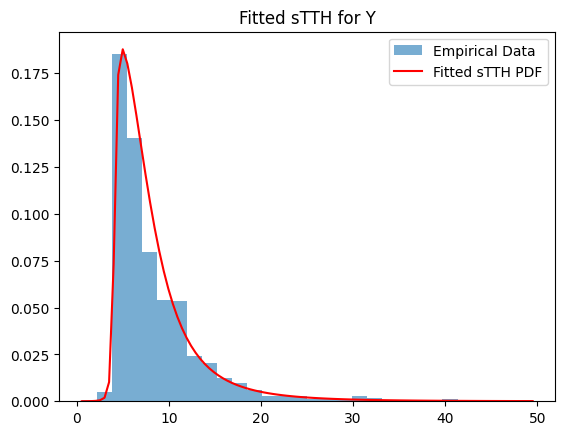

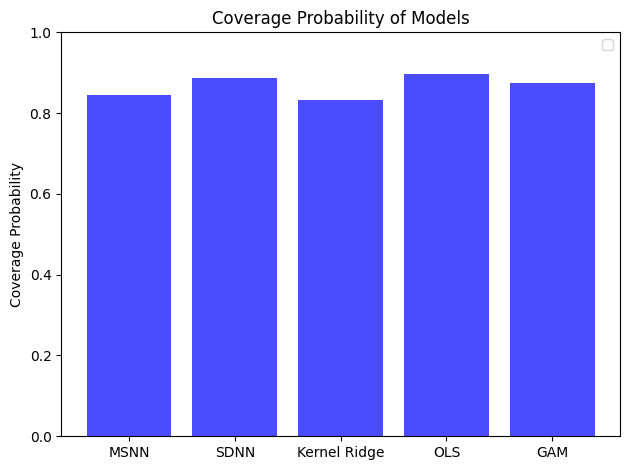

MSNN Coverage Probability: 0.8451
SDNN Coverage Probability: 0.8862
Kernel Ridge Coverage Probability: 0.8329
OLS Coverage Probability: 0.8972
GAM Coverage Probability: 0.8754


In [ ]:
######################################## Scenario-I: Univariate sTTH Residual
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s
from scipy.stats import norm, t
from scipy.special import lambertw
import matplotlib.pyplot as plt

# PDF of the sTTH distribution
def sTTH_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    W0 = lambertw(h * y_scaled**2).real
    w = np.exp(-0.5 * W0)
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    pdf = (2 / omega) * t_pdf * t_cdf * jacobian
    return pdf

# Simulate from the sTTH distribution using rejection sampling
def simulate_sTTH(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = sTTH_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

def bootstrap_coverage_modified(X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1):
    """
    Calculates coverage probability of models using residual-based confidence intervals.

    Args:
        X_train (numpy.ndarray): Training covariates.
        Y_train (numpy.ndarray): Training response variable.
        X_test (numpy.ndarray): Testing covariates.
        Y_test (numpy.ndarray): Testing response variable.
        models (dict): Dictionary containing models and their corresponding loss functions and optimizers.
        B (int): Number of bootstrap samples.
        alpha (float): Significance level for confidence intervals.

    Returns:
        dict: Coverage probabilities for each model.
    """
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    coverages = {model_name: [] for model_name in models.keys()}

    for b in range(B):
        # Bootstrap sampling
        indices = np.random.choice(n_train, n_train, replace=True)
        X_bootstrap = X_train[indices]
        Y_bootstrap = Y_train[indices]

        # Calculate residuals for train and test datasets
        for model_name, (model, loss_fn, optimizer_fn) in models.items():
            if model_name in ['MSNN', 'SDNN']:
                # Train the model
                model = train_model(model, loss_fn, optimizer_fn,
                                    torch.tensor(X_bootstrap, dtype=torch.float32),
                                    torch.tensor(Y_bootstrap, dtype=torch.float32).view(-1, 1))
                train_predictions = model(torch.tensor(X_bootstrap, dtype=torch.float32)).detach().numpy().flatten()
                test_predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
            elif model_name == 'Kernel Ridge':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'OLS':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'GAM':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)

            # Compute residuals
            train_residuals = Y_bootstrap - train_predictions
            test_residuals = Y_test - test_predictions

            # Calculate alpha and 1-alpha quantiles for train residuals
            lower_bound = np.percentile(train_residuals, alpha / 2 * 100)
            upper_bound = np.percentile(train_residuals, (1 - alpha / 2) * 100)

            # Calculate percentage of test residuals within the interval
            test_coverage = np.mean((test_residuals >= lower_bound) & (test_residuals <= upper_bound))
            coverages[model_name].append(test_coverage)

    # Average coverage probabilities
    avg_coverages = {model_name: np.mean(coverage_list) for model_name, coverage_list in coverages.items()}

    return avg_coverages


# Simulate covariates and response
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Simulate epsilon from the sTTH distribution
epsilon = simulate_sTTH(n, psi=5, omega=1, a=4, nu=5, h=10)

# Response variable
Y = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon
X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))

def log_likelihood(params, y):
    psi, omega, a, nu, h = params
    # Ensure omega > 0 and nu > 0 for valid parameters
    if omega <= 0 or nu <= 0:
        return np.inf  # Return a large value to penalize invalid parameters

    # Calculate the log-likelihood
    pdf_values = sTTH_pdf(y, psi, omega, a, nu, h)
    # Avoid log(0) or negative likelihoods
    if np.any(pdf_values <= 0):
        return np.inf
    log_likelihood_value = -np.sum(np.log(pdf_values))
    return log_likelihood_value

from scipy.optimize import minimize

# Initial guess for parameters
initial_params = [1, 1, 1, 2, 0.1]  # psi, omega, a, nu, h

# Fit sTTH to Y1
result_Y = minimize(log_likelihood, initial_params, args=(Y,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Extract fitted parameters
params_Y = result_Y.x

print("Fitted Parameters for Y1 (psi, omega, a, nu, h):", params_Y)
# print("Fitted Parameters for Y2 (psi, omega, a, nu, h):", params_Y2)
import matplotlib.pyplot as plt

# Evaluate the fitted PDF for Y1
y_vals = np.linspace(min(Y), max(Y), 100)
fitted_pdf_Y1 = sTTH_pdf(y_vals, *params_Y)

# Plot histogram and fitted PDF
plt.hist(Y, bins=30, density=True, alpha=0.6, label='Empirical Data')
plt.plot(y_vals, fitted_pdf_Y1, label='Fitted sTTH PDF', color='red')
plt.title('Fitted sTTH for Y')
plt.legend()
plt.show()

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

omega_1, a_1, nu_1 = params_Y[1],params_Y[2],params_Y[3]  # Parameters for Y1
# Define MSNN with Custom Loss
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

class CustomLoss(nn.Module):
    def __init__(self, nu= nu_1, omega = omega_1, a = a_1):
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            t.cdf((self.a * residuals / self.omega).detach().numpy(), df=self.nu), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss

# Define SDNN with MSE Loss
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Train a model
def train_model(model, loss_fn, optimizer, X_train, Y_train, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = loss_fn(predictions, Y_train)
        loss.backward()
        optimizer.step()
    return model


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# Bootstrap resampling for coverage probability

# Initialize models
msnn_model = MSNN(input_size=X_train.shape[1], hidden_size=128)
custom_loss_fn = CustomLoss()
msnn_optimizer = optim.Adam(msnn_model.parameters(), lr=0.1)

sdnn_model = SDNN(input_size=X_train.shape[1], hidden_size=12)
sdnn_loss_fn = nn.MSELoss()
sdnn_optimizer = optim.Adam(sdnn_model.parameters(), lr=0.001)

kr_model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)
ols_model = LinearRegression()
gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))

# Define models dictionary
models = {
    "MSNN": (msnn_model, custom_loss_fn, msnn_optimizer),
    "SDNN": (sdnn_model, sdnn_loss_fn, sdnn_optimizer),
    "Kernel Ridge": (kr_model, None, None),
    "OLS": (ols_model, None, None),
    "GAM": (gam_model, None, None),
}

# Calculate coverage probabilities
coverages = bootstrap_coverage_modified(X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1)

# Plot coverage probabilities
plt.bar(coverages.keys(), coverages.values(), color='blue', alpha=0.7)
# plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Coverage Probability")
plt.title("Coverage Probability of Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# Print coverage probabilities
for model_name, coverage in coverages.items():
    print(f"{model_name} Coverage Probability: {coverage:.4f}")


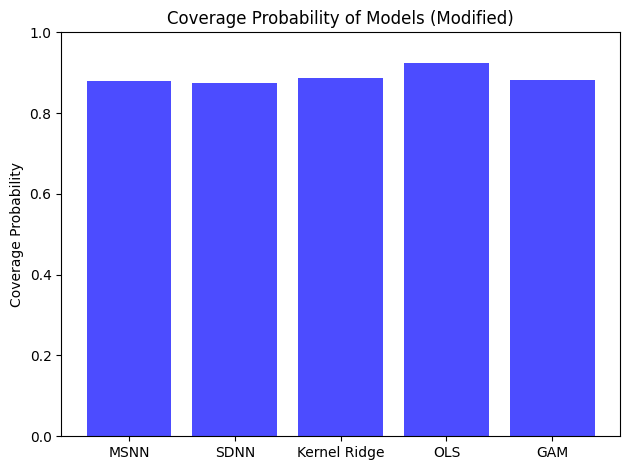

MSNN Coverage Probability (Modified): 0.8786
SDNN Coverage Probability (Modified): 0.8744
Kernel Ridge Coverage Probability (Modified): 0.8866
OLS Coverage Probability (Modified): 0.9232
GAM Coverage Probability (Modified): 0.8821


In [ ]:
def bootstrap_coverage_modified(X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1):
    """
    Calculates coverage probability of models using residual-based confidence intervals.

    Args:
        X_train (numpy.ndarray): Training covariates.
        Y_train (numpy.ndarray): Training response variable.
        X_test (numpy.ndarray): Testing covariates.
        Y_test (numpy.ndarray): Testing response variable.
        models (dict): Dictionary containing models and their corresponding loss functions and optimizers.
        B (int): Number of bootstrap samples.
        alpha (float): Significance level for confidence intervals.

    Returns:
        dict: Coverage probabilities for each model.
    """
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    coverages = {model_name: [] for model_name in models.keys()}

    for b in range(B):
        # Bootstrap sampling
        indices = np.random.choice(n_train, n_train, replace=True)
        X_bootstrap = X_train[indices]
        Y_bootstrap = Y_train[indices]

        # Calculate residuals for train and test datasets
        for model_name, (model, loss_fn, optimizer_fn) in models.items():
            if model_name in ['MSNN', 'SDNN']:
                # Train the model
                model = train_model(model, loss_fn, optimizer_fn,
                                    torch.tensor(X_bootstrap, dtype=torch.float32),
                                    torch.tensor(Y_bootstrap, dtype=torch.float32).view(-1, 1))
                train_predictions = model(torch.tensor(X_bootstrap, dtype=torch.float32)).detach().numpy().flatten()
                test_predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
            elif model_name == 'Kernel Ridge':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'OLS':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'GAM':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)

            # Compute residuals
            train_residuals = Y_bootstrap - train_predictions
            test_residuals = Y_test - test_predictions

            # Calculate alpha and 1-alpha quantiles for train residuals
            lower_bound = np.percentile(train_residuals, alpha / 2 * 100)
            upper_bound = np.percentile(train_residuals, (1 - alpha / 2) * 100)

            # Calculate percentage of test residuals within the interval
            test_coverage = np.mean((test_residuals >= lower_bound) & (test_residuals <= upper_bound))
            coverages[model_name].append(test_coverage)

    # Average coverage probabilities
    avg_coverages = {model_name: np.mean(coverage_list) for model_name, coverage_list in coverages.items()}

    return avg_coverages

# Calculate coverage probabilities using the modified method
modified_coverages = bootstrap_coverage_modified(X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1)

# Plot the modified coverage probabilities
plt.bar(modified_coverages.keys(), modified_coverages.values(), color='blue', alpha=0.7)
plt.ylabel("Coverage Probability")
plt.title("Coverage Probability of Models (Modified)")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Print modified coverage probabilities
for model_name, coverage in modified_coverages.items():
    print(f"{model_name} Coverage Probability (Modified): {coverage:.4f}")


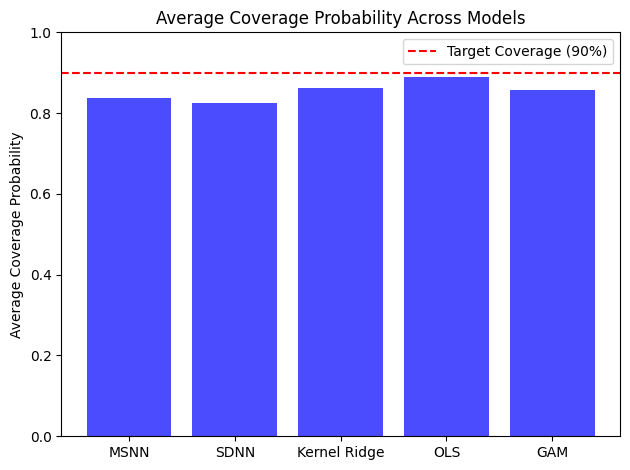

Coverage Probability for Y1: {'MSNN': 0.8397666666666668, 'SDNN': 0.836, 'Kernel Ridge': 0.8705000000000003, 'OLS': 0.8893, 'GAM': 0.860433333333333}
Coverage Probability for Y2: {'MSNN': 0.8339000000000003, 'SDNN': 0.8123666666666665, 'Kernel Ridge': 0.8518333333333332, 'OLS': 0.8908333333333333, 'GAM': 0.8538666666666666}
Average Coverage Probability: {'MSNN': 0.8368333333333335, 'SDNN': 0.8241833333333333, 'Kernel Ridge': 0.8611666666666667, 'OLS': 0.8900666666666666, 'GAM': 0.8571499999999999}


In [ ]:
############### Scenario-II: Bivariate Independent sTTH Residual #####################################################
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s
from scipy.stats import t
from scipy.special import lambertw
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sTTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sTTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

# Negative log-likelihood function for parameter fitting
def negative_log_likelihood(params, y):
    psi, omega, a, nu, h = params
    if omega <= 0 or nu <= 0 or h <= 0:
        return np.inf
    pdf_values = ssth_pdf(y, psi, omega, a, nu, h)
    if np.any(pdf_values <= 0):
        return np.inf
    return -np.sum(np.log(pdf_values))

# Fit sTTH parameters using optimization
def fit_ssth_parameters(y):
    initial_params = [np.mean(y), 1, 2, 2, 0.1]
    bounds = [(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)]
    result = minimize(negative_log_likelihood, initial_params, args=(y,), bounds=bounds, method="L-BFGS-B")
    return result.x

# Define MSNN Model
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define SDNN Model
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            t.cdf((self.a * residuals / self.omega).detach().numpy(), df=self.nu), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss

# Train a model
def train_model(model, loss_fn, optimizer, X_train, Y_train, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = loss_fn(predictions, Y_train)
        loss.backward()
        optimizer.step()
    return model

def bootstrap_coverage_modified(X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1):
    """
    Calculates coverage probability of models using residual-based confidence intervals.

    Args:
        X_train (numpy.ndarray): Training covariates.
        Y_train (numpy.ndarray): Training response variable.
        X_test (numpy.ndarray): Testing covariates.
        Y_test (numpy.ndarray): Testing response variable.
        models (dict): Dictionary containing models and their corresponding loss functions and optimizers.
        B (int): Number of bootstrap samples.
        alpha (float): Significance level for confidence intervals.

    Returns:
        dict: Coverage probabilities for each model.
    """
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    coverages = {model_name: [] for model_name in models.keys()}

    for b in range(B):
        # Bootstrap sampling
        indices = np.random.choice(n_train, n_train, replace=True)
        X_bootstrap = X_train[indices]
        Y_bootstrap = Y_train[indices]

        # Calculate residuals for train and test datasets
        for model_name, (model, loss_fn, optimizer_fn) in models.items():
            if model_name in ['MSNN', 'SDNN']:
                # Train the model
                model = train_model(model, loss_fn, optimizer_fn,
                                    torch.tensor(X_bootstrap, dtype=torch.float32),
                                    torch.tensor(Y_bootstrap, dtype=torch.float32).view(-1, 1))
                train_predictions = model(torch.tensor(X_bootstrap, dtype=torch.float32)).detach().numpy().flatten()
                test_predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
            elif model_name == 'Kernel Ridge':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'OLS':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'GAM':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)

            # Compute residuals
            train_residuals = Y_bootstrap - train_predictions
            test_residuals = Y_test - test_predictions

            # Calculate alpha and 1-alpha quantiles for train residuals
            lower_bound = np.percentile(train_residuals, alpha / 2 * 100)
            upper_bound = np.percentile(train_residuals, (1 - alpha / 2) * 100)

            # Calculate percentage of test residuals within the interval
            test_coverage = np.mean((test_residuals >= lower_bound) & (test_residuals <= upper_bound))
            coverages[model_name].append(test_coverage)

    # Average coverage probabilities
    avg_coverages = {model_name: np.mean(coverage_list) for model_name, coverage_list in coverages.items()}

    return avg_coverages



# Simulate Data
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

epsilon_1 = simulate_ssth(n, psi=4, omega=1, a=2, nu=2, h=0.3)
epsilon_2 = simulate_ssth(n, psi=2, omega=2, a=4, nu=3, h=0.5)

# epsilon_1_uniform = to_uniform(epsilon_1)
# epsilon_2_uniform = to_uniform(epsilon_2)

Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1
Y2 = Z1 * Z2**2 + Z3 * Z4 + Z5 * Z6 + epsilon_2

X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))

# Fit sTTH parameters for Y1 and Y2
params_Y1 = fit_ssth_parameters(Y1)
params_Y2 = fit_ssth_parameters(Y2)

# Split Data for Responses
X_train_Y1, X_test_Y1, Y_train_Y1, Y_test_Y1 = train_test_split(X, Y1, test_size=0.3, random_state=42)
X_train_Y2, X_test_Y2, Y_train_Y2, Y_test_Y2 = train_test_split(X, Y2, test_size=0.3, random_state=42)

# Initialize Models for Y1
msnn_model_Y1 = MSNN(input_size=X_train_Y1.shape[1], hidden_size=128)
sdnn_model_Y1 = SDNN(input_size=X_train_Y1.shape[1], hidden_size=12)
custom_loss_fn_Y1 = CustomLoss(nu=params_Y1[3], omega=params_Y1[1], a=params_Y1[2])
msnn_optimizer_Y1 = optim.Adam(msnn_model_Y1.parameters(), lr=0.1)
sdnn_optimizer_Y1 = optim.Adam(sdnn_model_Y1.parameters(), lr=0.01)

# Initialize Models for Y2
msnn_model_Y2 = MSNN(input_size=X_train_Y2.shape[1], hidden_size=128)
sdnn_model_Y2 = SDNN(input_size=X_train_Y2.shape[1], hidden_size=12)
custom_loss_fn_Y2 = CustomLoss(nu=params_Y2[3], omega=params_Y2[1], a=params_Y2[2])
msnn_optimizer_Y2 = optim.Adam(msnn_model_Y2.parameters(), lr=0.1)
sdnn_optimizer_Y2 = optim.Adam(sdnn_model_Y2.parameters(), lr=0.01)

# Common Models
kr_model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)
ols_model = LinearRegression()
gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))

models_Y1 = {
    "MSNN": (msnn_model_Y1, custom_loss_fn_Y1, msnn_optimizer_Y1),
    "SDNN": (sdnn_model_Y1, nn.MSELoss(), sdnn_optimizer_Y1),
    "Kernel Ridge": (kr_model, None, None),
    "OLS": (ols_model, None, None),
    "GAM": (gam_model, None, None),
}

models_Y2 = {
    "MSNN": (msnn_model_Y2, custom_loss_fn_Y2, msnn_optimizer_Y2),
    "SDNN": (sdnn_model_Y2, nn.MSELoss(), sdnn_optimizer_Y2),
    "Kernel Ridge": (kr_model, None, None),
    "OLS": (ols_model, None, None),
    "GAM": (gam_model, None, None),
}

# Coverage Probabilities
# Calculate coverage probabilities using the modified method
# modified_coverages = (X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1)
coverage_Y1 = bootstrap_coverage_modified(X_train_Y1, Y_train_Y1, X_test_Y1, Y_test_Y1, models_Y1, B=100, alpha=0.1)
coverage_Y2 =bootstrap_coverage_modified (X_train_Y2, Y_train_Y2, X_test_Y2, Y_test_Y2, models_Y2, B=100, alpha=0.1)

# Average Coverage
average_coverage_indep = {model: (coverage_Y1[model] + coverage_Y2[model]) / 2 for model in coverage_Y1.keys()}

# Plot Coverage Probabilities
plt.bar(average_coverage_indep.keys(), average_coverage_indep.values(), color='blue', alpha=0.7)
plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Average Coverage Probability")
plt.title("Average Coverage Probability Across Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# Print Results
print("Coverage Probability for Y1:", coverage_Y1)
print("Coverage Probability for Y2:", coverage_Y2)
print("Average Coverage Probability:", average_coverage_indep)


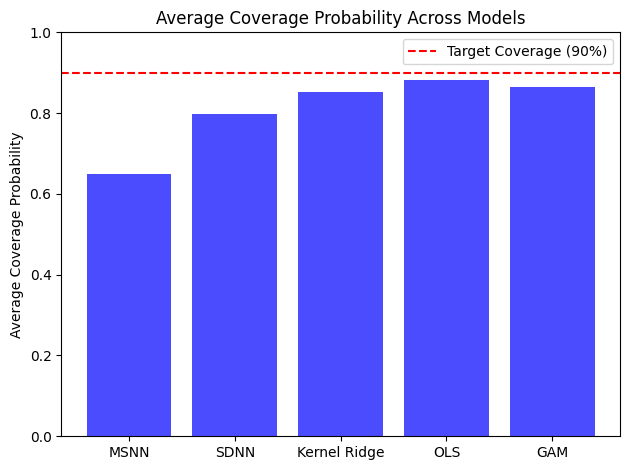

Coverage Probability for Y1: {'MSNN': 0.6684666666666665, 'SDNN': 0.8378333333333332, 'Kernel Ridge': 0.8671666666666665, 'OLS': 0.8899000000000001, 'GAM': 0.8717333333333335}
Coverage Probability for Y2: {'MSNN': 0.6309, 'SDNN': 0.7557333333333333, 'Kernel Ridge': 0.8379333333333334, 'OLS': 0.8729333333333333, 'GAM': 0.8566333333333334}
Average Coverage Probability: {'MSNN': 0.6496833333333333, 'SDNN': 0.7967833333333332, 'Kernel Ridge': 0.8525499999999999, 'OLS': 0.8814166666666667, 'GAM': 0.8641833333333334}


In [ ]:
############### Scenario-III: Bivariate SN Residual #####################################################
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s
from scipy.stats import t
from scipy.special import lambertw
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sTTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sTTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

# Negative log-likelihood function for parameter fitting
def negative_log_likelihood(params, y):
    psi, omega, a, nu, h = params
    if omega <= 0 or nu <= 0 or h <= 0:
        return np.inf
    pdf_values = ssth_pdf(y, psi, omega, a, nu, h)
    if np.any(pdf_values <= 0):
        return np.inf
    return -np.sum(np.log(pdf_values))

# Fit sTTH parameters using optimization
def fit_ssth_parameters(y):
    initial_params = [np.mean(y), 1, 2, 2, 0.1]
    bounds = [(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)]
    result = minimize(negative_log_likelihood, initial_params, args=(y,), bounds=bounds, method="L-BFGS-B")
    return result.x

# Define MSNN Model
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define SDNN Model
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            t.cdf((self.a * residuals / self.omega).detach().numpy(), df=self.nu), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss

# Train a model
def train_model(model, loss_fn, optimizer, X_train, Y_train, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = loss_fn(predictions, Y_train)
        loss.backward()
        optimizer.step()
    return model


def bootstrap_coverage_modified(X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1):
    """
    Calculates coverage probability of models using residual-based confidence intervals.

    Args:
        X_train (numpy.ndarray): Training covariates.
        Y_train (numpy.ndarray): Training response variable.
        X_test (numpy.ndarray): Testing covariates.
        Y_test (numpy.ndarray): Testing response variable.
        models (dict): Dictionary containing models and their corresponding loss functions and optimizers.
        B (int): Number of bootstrap samples.
        alpha (float): Significance level for confidence intervals.

    Returns:
        dict: Coverage probabilities for each model.
    """
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    coverages = {model_name: [] for model_name in models.keys()}

    for b in range(B):
        # Bootstrap sampling
        indices = np.random.choice(n_train, n_train, replace=True)
        X_bootstrap = X_train[indices]
        Y_bootstrap = Y_train[indices]

        # Calculate residuals for train and test datasets
        for model_name, (model, loss_fn, optimizer_fn) in models.items():
            if model_name in ['MSNN', 'SDNN']:
                # Train the model
                model = train_model(model, loss_fn, optimizer_fn,
                                    torch.tensor(X_bootstrap, dtype=torch.float32),
                                    torch.tensor(Y_bootstrap, dtype=torch.float32).view(-1, 1))
                train_predictions = model(torch.tensor(X_bootstrap, dtype=torch.float32)).detach().numpy().flatten()
                test_predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
            elif model_name == 'Kernel Ridge':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'OLS':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'GAM':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)

            # Compute residuals
            train_residuals = Y_bootstrap - train_predictions
            test_residuals = Y_test - test_predictions

            # Calculate alpha and 1-alpha quantiles for train residuals
            lower_bound = np.percentile(train_residuals, alpha / 2 * 100)
            upper_bound = np.percentile(train_residuals, (1 - alpha / 2) * 100)

            # Calculate percentage of test residuals within the interval
            test_coverage = np.mean((test_residuals >= lower_bound) & (test_residuals <= upper_bound))
            coverages[model_name].append(test_coverage)

    # Average coverage probabilities
    avg_coverages = {model_name: np.mean(coverage_list) for model_name, coverage_list in coverages.items()}

    return avg_coverages

# Simulate Data
# Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Simulate from bivariate skew normal distribution
def simulate_bivariate_skew_normal(n, loc, scale, alpha, correlation):
    """
    Simulate n samples from a bivariate skew normal distribution.
    :param n: Number of samples.
    :param loc: Mean vector of length 2.
    :param scale: Standard deviation vector of length 2.
    :param alpha: Skewness vector of length 2 (as a NumPy array).
    :param correlation: Correlation coefficient between the two variables.
    :return: n x 2 array of simulated samples.
    """
    # Convert alpha to a NumPy array if not already
    alpha = np.array(alpha)

    # Correlation matrix
    cov_matrix = np.array([
        [scale[0]**2, correlation * scale[0] * scale[1]],
        [correlation * scale[0] * scale[1], scale[1]**2]
    ])

    # Generate base samples from multivariate normal
    mvn = multivariate_normal(mean=loc, cov=cov_matrix)
    Z = mvn.rvs(size=n)

    # Apply skewness transformation
    delta = alpha / np.sqrt(1 + alpha**2)  # Delta for each variable
    u = norm.cdf(delta[0] * Z[:, 0] + delta[1] * Z[:, 1])  # Skewing variable
    skewed_samples = Z + np.outer(norm.ppf(u), delta)

    return skewed_samples

# Parameters for the bivariate skew normal
loc = [4, 2]             # Mean vector
scale = [1, 2]           # Standard deviations
alpha = [2, -3]          # Skewness for each variable
correlation = 0.5        # Correlation between variables

# Simulate epsilon_1 and epsilon_2
epsilon_samples = simulate_bivariate_skew_normal(n, loc, scale, alpha, correlation)
epsilon_1, epsilon_2 = epsilon_samples[:, 0], epsilon_samples[:, 1]

# Transform marginals to [0, 1] using empirical CDF

# Simulate response variables
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1
Y2 = Z1 * Z2**2 + Z3 * Z4 + Z5 * Z6 + epsilon_2
X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = np.column_stack((Y1, Y2))

# Fit sTTH parameters for Y1 and Y2
params_Y1 = fit_ssth_parameters(Y1)
params_Y2 = fit_ssth_parameters(Y2)

# Split Data for Responses
X_train_Y1, X_test_Y1, Y_train_Y1, Y_test_Y1 = train_test_split(X, Y1, test_size=0.3, random_state=42)
X_train_Y2, X_test_Y2, Y_train_Y2, Y_test_Y2 = train_test_split(X, Y2, test_size=0.3, random_state=42)

# Initialize Models for Y1
msnn_model_Y1 = MSNN(input_size=X_train_Y1.shape[1], hidden_size=128)
sdnn_model_Y1 = SDNN(input_size=X_train_Y1.shape[1], hidden_size=12)
custom_loss_fn_Y1 = CustomLoss(nu=params_Y1[3], omega=params_Y1[1], a=params_Y1[2])
msnn_optimizer_Y1 = optim.Adam(msnn_model_Y1.parameters(), lr=0.1)
sdnn_optimizer_Y1 = optim.Adam(sdnn_model_Y1.parameters(), lr=0.01)

# Initialize Models for Y2
msnn_model_Y2 = MSNN(input_size=X_train_Y2.shape[1], hidden_size=128)
sdnn_model_Y2 = SDNN(input_size=X_train_Y2.shape[1], hidden_size=12)
custom_loss_fn_Y2 = CustomLoss(nu=params_Y2[3], omega=params_Y2[1], a=params_Y2[2])
msnn_optimizer_Y2 = optim.Adam(msnn_model_Y2.parameters(), lr=0.1)
sdnn_optimizer_Y2 = optim.Adam(sdnn_model_Y2.parameters(), lr=0.01)

# Common Models
kr_model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)
ols_model = LinearRegression()
gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))

models_Y1 = {
    "MSNN": (msnn_model_Y1, custom_loss_fn_Y1, msnn_optimizer_Y1),
    "SDNN": (sdnn_model_Y1, nn.MSELoss(), sdnn_optimizer_Y1),
    "Kernel Ridge": (kr_model, None, None),
    "OLS": (ols_model, None, None),
    "GAM": (gam_model, None, None),
}

models_Y2 = {
    "MSNN": (msnn_model_Y2, custom_loss_fn_Y2, msnn_optimizer_Y2),
    "SDNN": (sdnn_model_Y2, nn.MSELoss(), sdnn_optimizer_Y2),
    "Kernel Ridge": (kr_model, None, None),
    "OLS": (ols_model, None, None),
    "GAM": (gam_model, None, None),
}

# Coverage Probabilities
coverage_Y1 = bootstrap_coverage_modified(X_train_Y1, Y_train_Y1, X_test_Y1, Y_test_Y1, models_Y1, B=100, alpha=0.1)
coverage_Y2 = bootstrap_coverage_modified(X_train_Y2, Y_train_Y2, X_test_Y2, Y_test_Y2, models_Y2, B=100, alpha=0.1)

# Average Coverage
average_coverage_sn = {model: (coverage_Y1[model] + coverage_Y2[model]) / 2 for model in coverage_Y1.keys()}

# Plot Coverage Probabilities
plt.bar(average_coverage_sn.keys(), average_coverage_sn.values(), color='blue', alpha=0.7)
plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Average Coverage Probability")
plt.title("Average Coverage Probability Across Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# Print Results
print("Coverage Probability for Y1:", coverage_Y1)
print("Coverage Probability for Y2:", coverage_Y2)
print("Average Coverage Probability:", average_coverage_sn)


In [ ]:
!pip install copulas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.6 MB/s eta 0:00:00


Estimated Frank Copula Parameter (theta): 0.1854137627663701


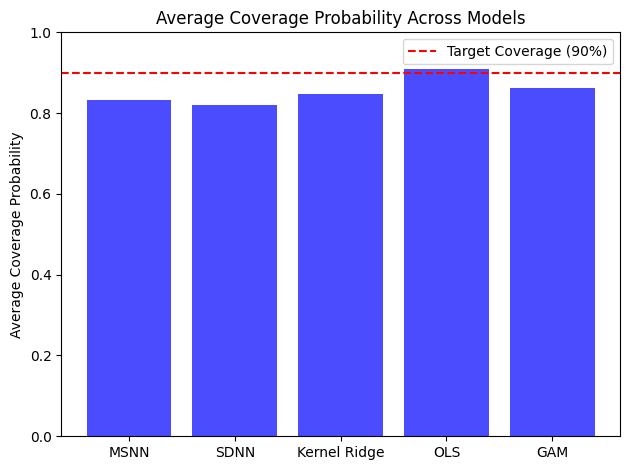

Coverage Probability for Y1: {'MSNN': 0.8139333333333333, 'SDNN': 0.7969999999999999, 'Kernel Ridge': 0.8320333333333333, 'OLS': 0.8984333333333333, 'GAM': 0.8498333333333334}
Coverage Probability for Y2: {'MSNN': 0.8519999999999998, 'SDNN': 0.8417333333333333, 'Kernel Ridge': 0.863, 'OLS': 0.9180666666666667, 'GAM': 0.8769333333333332}
Average Coverage Probability: {'MSNN': 0.8329666666666665, 'SDNN': 0.8193666666666666, 'Kernel Ridge': 0.8475166666666667, 'OLS': 0.90825, 'GAM': 0.8633833333333334}


In [ ]:
############### Scenario-IV: Bivariate Copula Residual #####################################################
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s
from scipy.stats import t
from scipy.special import lambertw
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sTTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sTTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

# Negative log-likelihood function for parameter fitting
def negative_log_likelihood(params, y):
    psi, omega, a, nu, h = params
    if omega <= 0 or nu <= 0 or h <= 0:
        return np.inf
    pdf_values = ssth_pdf(y, psi, omega, a, nu, h)
    if np.any(pdf_values <= 0):
        return np.inf
    return -np.sum(np.log(pdf_values))

# Fit sTTH parameters using optimization
def fit_ssth_parameters(y):
    initial_params = [np.mean(y), 1, 2, 2, 0.1]
    bounds = [(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)]
    result = minimize(negative_log_likelihood, initial_params, args=(y,), bounds=bounds, method="L-BFGS-B")
    return result.x

# Define MSNN Model
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define SDNN Model
class SDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            t.cdf((self.a * residuals / self.omega).detach().numpy(), df=self.nu), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss

# Train a model
def train_model(model, loss_fn, optimizer, X_train, Y_train, epochs=100):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = loss_fn(predictions, Y_train)
        loss.backward()
        optimizer.step()
    return model

# Bootstrap Coverage Probability
def bootstrap_coverage_modified(X_train, Y_train, X_test, Y_test, models, B=100, alpha=0.1):
    """
    Calculates coverage probability of models using residual-based confidence intervals.

    Args:
        X_train (numpy.ndarray): Training covariates.
        Y_train (numpy.ndarray): Training response variable.
        X_test (numpy.ndarray): Testing covariates.
        Y_test (numpy.ndarray): Testing response variable.
        models (dict): Dictionary containing models and their corresponding loss functions and optimizers.
        B (int): Number of bootstrap samples.
        alpha (float): Significance level for confidence intervals.

    Returns:
        dict: Coverage probabilities for each model.
    """
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    coverages = {model_name: [] for model_name in models.keys()}

    for b in range(B):
        # Bootstrap sampling
        indices = np.random.choice(n_train, n_train, replace=True)
        X_bootstrap = X_train[indices]
        Y_bootstrap = Y_train[indices]

        # Calculate residuals for train and test datasets
        for model_name, (model, loss_fn, optimizer_fn) in models.items():
            if model_name in ['MSNN', 'SDNN']:
                # Train the model
                model = train_model(model, loss_fn, optimizer_fn,
                                    torch.tensor(X_bootstrap, dtype=torch.float32),
                                    torch.tensor(Y_bootstrap, dtype=torch.float32).view(-1, 1))
                train_predictions = model(torch.tensor(X_bootstrap, dtype=torch.float32)).detach().numpy().flatten()
                test_predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
            elif model_name == 'Kernel Ridge':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'OLS':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)
            elif model_name == 'GAM':
                model.fit(X_bootstrap, Y_bootstrap)
                train_predictions = model.predict(X_bootstrap)
                test_predictions = model.predict(X_test)

            # Compute residuals
            train_residuals = Y_bootstrap - train_predictions
            test_residuals = Y_test - test_predictions

            # Calculate alpha and 1-alpha quantiles for train residuals
            lower_bound = np.percentile(train_residuals, alpha / 2 * 100)
            upper_bound = np.percentile(train_residuals, (1 - alpha / 2) * 100)

            # Calculate percentage of test residuals within the interval
            test_coverage = np.mean((test_residuals >= lower_bound) & (test_residuals <= upper_bound))
            coverages[model_name].append(test_coverage)

    # Average coverage probabilities
    avg_coverages = {model_name: np.mean(coverage_list) for model_name, coverage_list in coverages.items()}

    return avg_coverages

import numpy as np
from scipy.stats import rankdata, t
from scipy.special import lambertw
from copulas.bivariate import Frank
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.kernel_ridge import KernelRidge
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pygam import LinearGAM, s

# Step 1: Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sTTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sTTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant (adjust for higher acceptance rate)
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

# Step 2: Simulate residuals (\epsilon_1, \epsilon_2)
epsilon_1 = simulate_ssth(n, psi=4, omega=1, a=2, nu=2, h=0.3)
epsilon_2 = simulate_ssth(n, psi=2, omega=2, a=4, nu=3, h=0.5)

# Step 3: Transform residuals to uniform [0, 1]
def to_uniform(data):
    ranks = rankdata(data, method='average')
    return (ranks - 1) / (len(data) - 1)

u1 = to_uniform(epsilon_1)
u2 = to_uniform(epsilon_2)

# Step 4: Fit Frank Copula
frank = Frank()

# Fit the copula using the uniform marginals
frank.fit(np.column_stack((u1, u2)))

# Print the estimated theta
theta = frank.theta
print(f"Estimated Frank Copula Parameter (theta): {theta}")

# Step 5: Simulate bivariate residuals using Frank copula
simulated_u = frank.sample(n)  # Generate bivariate samples

simulated_epsilon_1 = np.percentile(epsilon_1, simulated_u[:, 0] * 100)
simulated_epsilon_2 = np.percentile(epsilon_2, simulated_u[:, 1] * 100)

# Step 6: Construct Y1 and Y2
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + simulated_epsilon_1
Y2 = Z1 * Z2**2 + Z1 * Z3 * Z4 + Z5 * Z6 + simulated_epsilon_2
X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = np.column_stack((Y1, Y2))

# Fit sTTH parameters for Y1 and Y2
params_Y1 = fit_ssth_parameters(Y1)
params_Y2 = fit_ssth_parameters(Y2)

# Split Data for Responses
X_train_Y1, X_test_Y1, Y_train_Y1, Y_test_Y1 = train_test_split(X, Y1, test_size=0.3, random_state=42)
X_train_Y2, X_test_Y2, Y_train_Y2, Y_test_Y2 = train_test_split(X, Y2, test_size=0.3, random_state=42)

# Initialize Models for Y1
msnn_model_Y1 = MSNN(input_size=X_train_Y1.shape[1], hidden_size=128)
sdnn_model_Y1 = SDNN(input_size=X_train_Y1.shape[1], hidden_size=12)
custom_loss_fn_Y1 = CustomLoss(nu=params_Y1[3], omega=params_Y1[1], a=params_Y1[2])
msnn_optimizer_Y1 = optim.Adam(msnn_model_Y1.parameters(), lr=0.1)
sdnn_optimizer_Y1 = optim.Adam(sdnn_model_Y1.parameters(), lr=0.01)

# Initialize Models for Y2
msnn_model_Y2 = MSNN(input_size=X_train_Y2.shape[1], hidden_size=128)
sdnn_model_Y2 = SDNN(input_size=X_train_Y2.shape[1], hidden_size=12)
custom_loss_fn_Y2 = CustomLoss(nu=params_Y2[3], omega=params_Y2[1], a=params_Y2[2])
msnn_optimizer_Y2 = optim.Adam(msnn_model_Y2.parameters(), lr=0.1)
sdnn_optimizer_Y2 = optim.Adam(sdnn_model_Y2.parameters(), lr=0.01)

# Common Models
kr_model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)
ols_model = LinearRegression()
gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))

models_Y1 = {
    "MSNN": (msnn_model_Y1, custom_loss_fn_Y1, msnn_optimizer_Y1),
    "SDNN": (sdnn_model_Y1, nn.MSELoss(), sdnn_optimizer_Y1),
    "Kernel Ridge": (kr_model, None, None),
    "OLS": (ols_model, None, None),
    "GAM": (gam_model, None, None),
}

models_Y2 = {
    "MSNN": (msnn_model_Y2, custom_loss_fn_Y2, msnn_optimizer_Y2),
    "SDNN": (sdnn_model_Y2, nn.MSELoss(), sdnn_optimizer_Y2),
    "Kernel Ridge": (kr_model, None, None),
    "OLS": (ols_model, None, None),
    "GAM": (gam_model, None, None),
}

# Coverage Probabilities
coverage_Y1 = bootstrap_coverage_modified(X_train_Y1, Y_train_Y1, X_test_Y1, Y_test_Y1, models_Y1, B=100, alpha=0.1)
coverage_Y2 = bootstrap_coverage_modified(X_train_Y2, Y_train_Y2, X_test_Y2, Y_test_Y2, models_Y2, B=100, alpha=0.1)

# Average Coverage
average_coverage_cop = {model: (coverage_Y1[model] + coverage_Y2[model]) / 2 for model in coverage_Y1.keys()}

# Plot Coverage Probabilities
plt.bar(average_coverage_cop.keys(), average_coverage_cop.values(), color='blue', alpha=0.7)
plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Average Coverage Probability")
plt.title("Average Coverage Probability Across Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# Print Results
print("Coverage Probability for Y1:", coverage_Y1)
print("Coverage Probability for Y2:", coverage_Y2)
print("Average Coverage Probability:", average_coverage_cop)


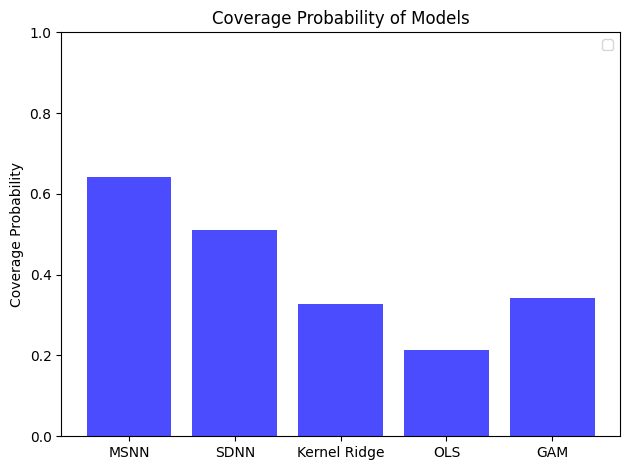

In [ ]:
# Calculate coverage probabilities
# coverages = bootstrap_coverage(X_train, Y_train, X, Y, models, B=100, alpha=0.1)

# Plot coverage probabilities
plt.bar(coverages.keys(), coverages.values(), color='blue', alpha=0.7)
# plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Coverage Probability")
plt.title("Coverage Probability of Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


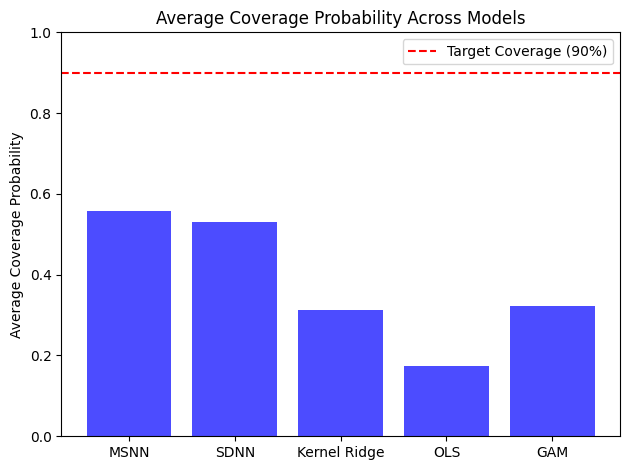

In [ ]:
# Plot Coverage Probabilities
plt.bar(average_coverage_indep.keys(), average_coverage_indep.values(), color='blue', alpha=0.7)
plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Average Coverage Probability")
plt.title("Average Coverage Probability Across Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


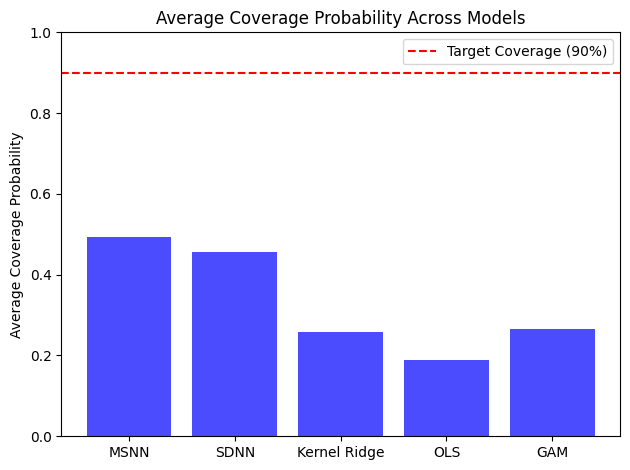

In [ ]:
# Plot Coverage Probabilities
plt.bar(average_coverage_sn.keys(), average_coverage_sn.values(), color='blue', alpha=0.7)
plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Average Coverage Probability")
plt.title("Average Coverage Probability Across Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
average_coverage_cop

{'MSNN': 0.5683333333333334,
 'SDNN': 0.52,
 'Kernel Ridge': 0.28500000000000003,
 'OLS': 0.145,
 'GAM': 0.2866666666666666}

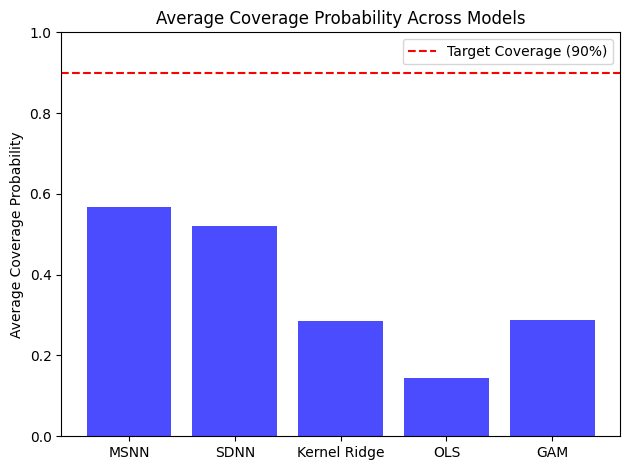

In [ ]:
# Plot Coverage Probabilities
plt.bar(average_coverage_cop.keys(), average_coverage_cop.values(), color='blue', alpha=0.7)
plt.axhline(y=0.9, color='red', linestyle='--', label='Target Coverage (90%)')
plt.ylabel("Average Coverage Probability")
plt.title("Average Coverage Probability Across Models")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

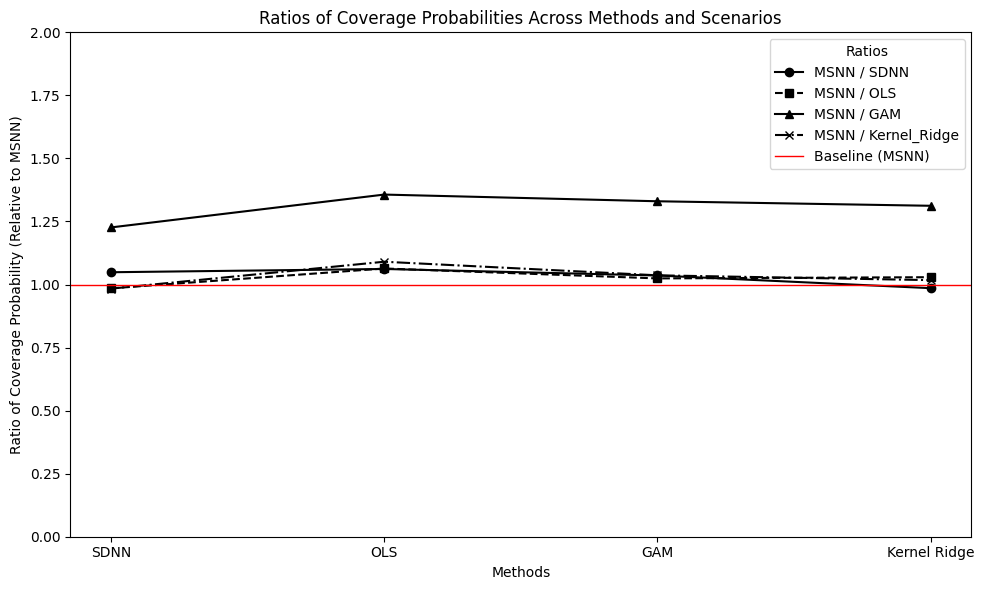

In [ ]:
# Calculate ratios for each scenario (excluding MSNN/MSNN)
ratios = {}
methods = ["SDNN", "OLS", "GAM", "Kernel Ridge"]

for scenario, data in zip(
    ["Scenario-I", "Scenario-II", "Scenario-III", "Scenario-IV"],
    [coverages, average_coverage_indep, average_coverage_sn, average_coverage_cop],
):
    ratios[scenario] = {method: data[method] / data["MSNN"] for method in methods}

# Display the ratios
import pandas as pd
ratios_df = pd.DataFrame(ratios)
ratios_df.index.name = "Methods"
# Rename columns
ratios_df.columns = [
    "ratio_sdnn_msnn",
    "ratio_ols_msnn",
    "ratio_gam_msnn",
    "ratio_kernel_ridge_msnn"
]
ratios_df.head()
import matplotlib.pyplot as plt

# Define different point shapes, colors, and legend labels for methods
methods = ratios_df.columns
scenarios = ratios_df.index
point_shapes = ['o', 's', '^', 'x']  # Circle, square, triangle, cross
colors = ['black', 'black', 'black', 'black']  # Different colors for methods
line_style = ['-', '--', '-', '-.']
legend_labels = ["MSNN / SDNN", "MSNN / OLS", "MSNN / GAM", "MSNN / Kernel_Ridge"]

# Create the plot
plt.figure(figsize=(10, 6))

for i, method in enumerate(methods):
    plt.plot(
        scenarios, ratios_df[method],
        marker=point_shapes[i],
        linestyle=line_style[i],
        color=colors[i],
        label=legend_labels[i]
    )

# Add labels and title
plt.ylabel("Ratio of Coverage Probability (Relative to MSNN)")
plt.xlabel("Methods")
plt.title("Ratios of Coverage Probabilities Across Methods and Scenarios")
plt.axhline(y=1, color='red', linestyle='-', linewidth=1, label='Baseline (MSNN)')
plt.ylim(0, 2)  # Set y-axis level to range from 0 to 2
plt.legend(title="Ratios")

# Display the plot
plt.tight_layout()
plt.savefig("coverage_prob.pdf")


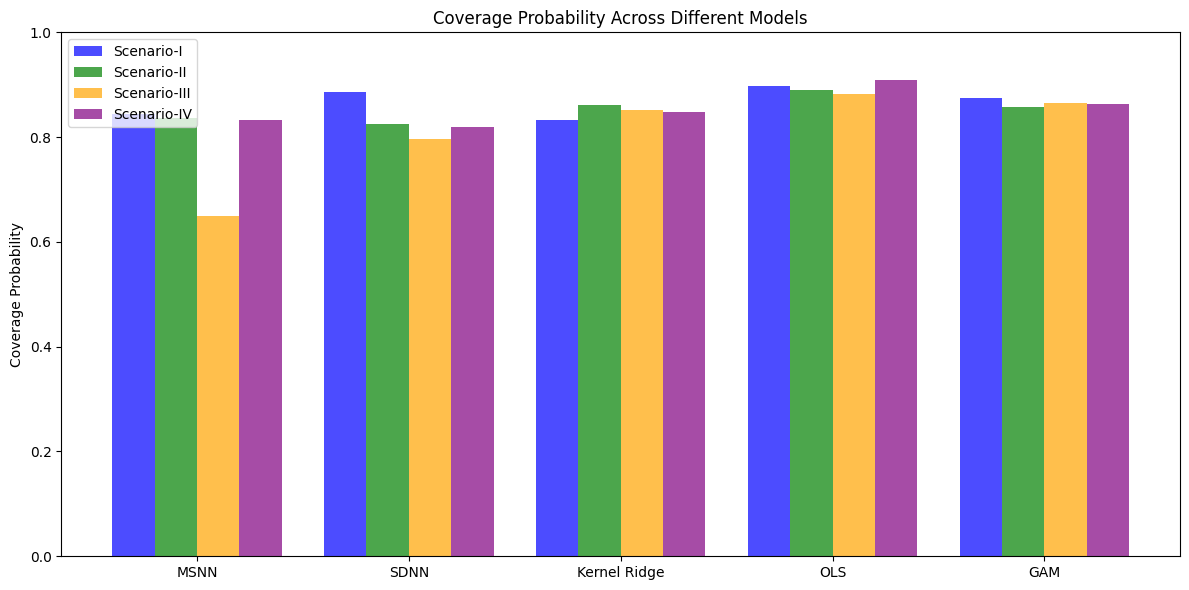

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Combine all keys (models)
models = list(average_coverage_indep.keys())

# Extract coverage probabilities for each scenario
indep_values = [average_coverage_indep[model] for model in models]
sn_values = [average_coverage_sn[model] for model in models]
cop_values = [average_coverage_cop[model] for model in models]
other_values = [coverages[model] for model in models]

# Create a grouped bar chart
x = np.arange(len(models))  # The label locations
bar_width = 0.2  # Width of each bar

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width * 1.5, other_values, width=bar_width, label='Scenario-I', color='blue', alpha=0.7)
plt.bar(x - bar_width / 2,indep_values , width=bar_width, label='Scenario-II', color='green', alpha=0.7)
plt.bar(x + bar_width / 2,sn_values, width=bar_width, label='Scenario-III', color='orange', alpha=0.7)
plt.bar(x + bar_width * 1.5, cop_values, width=bar_width, label='Scenario-IV', color='purple', alpha=0.7)

# Add labels and title
plt.xticks(x, models)  # Set model names as x-tick labels
plt.ylabel("Coverage Probability")
plt.title("Coverage Probability Across Different Models")
plt.ylim(0, 1.0)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("cp_sim.pdf")


# Variable Importance

Epoch 10/100, Loss: 30221.2441
Epoch 20/100, Loss: 26641.3340
Epoch 30/100, Loss: 22437.4844
Epoch 40/100, Loss: 19662.0293
Epoch 50/100, Loss: 16250.7852
Epoch 60/100, Loss: 12486.2920
Epoch 70/100, Loss: 9445.0918
Epoch 80/100, Loss: 7907.6699
Epoch 90/100, Loss: 7482.4253
Epoch 100/100, Loss: 7208.6255


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

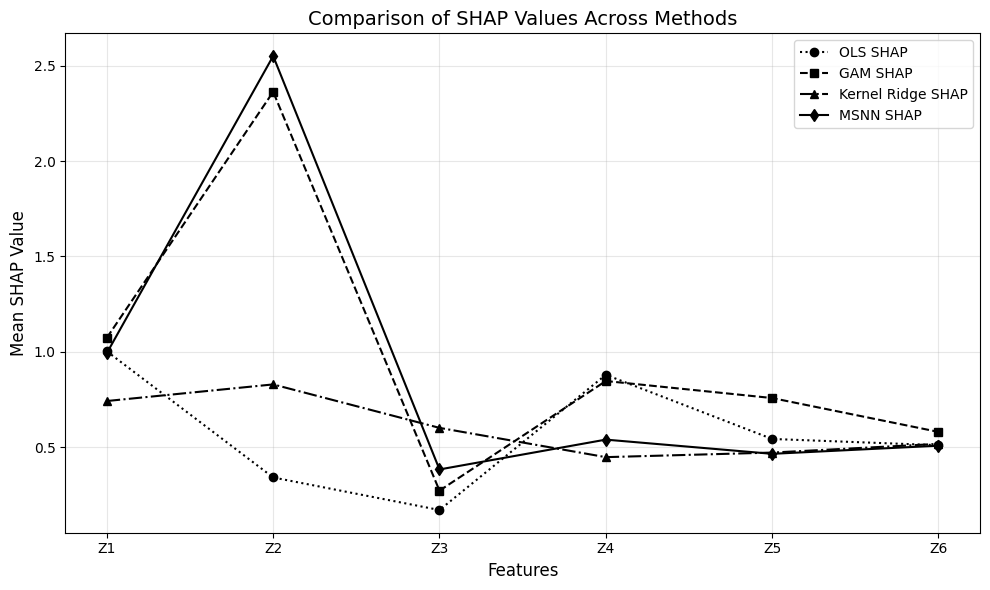

In [ ]:
##################################################### SHAP Values For Scenario-I #################################
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from pygam import LinearGAM, s
import shap
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.special import lambertw

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sSTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sSTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

# Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

epsilon_1 = simulate_ssth(n, psi=5, omega=1, a=4, nu=5, h=10)

# Simulate response variables
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1

X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = Y1.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Convert data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Define MSNN Model
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Custom Loss
class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        residuals_np = residuals.detach().numpy()
        term2 = 1 + torch.tensor(t.cdf(self.a * residuals_np / self.omega, df=self.nu), dtype=torch.float32)
        term3 = residuals**2
        loss = torch.sum(term1 * term3)
        return loss

# Train MSNN
input_size = X_train.shape[1]
hidden_size = 32
output_size = 1

msnn_model = MSNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(msnn_model.parameters(), lr=0.01)

# Initial guess for parameters
initial_params = [1, 1, 1, 2, 0.1]  # psi, omega, a, nu, h

# Fit sTTH to Y1
result_Y = minimize(log_likelihood, initial_params, args=(Y1,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Extract fitted parameters
params_Y = result_Y.x
# Initialize CustomLoss with parameters
nu, omega, a = params_Y[1],params_Y[2],params_Y[3]
loss_fn = CustomLoss(nu, omega, a)

epochs = 100
for epoch in range(epochs):
    msnn_model.train()
    optimizer.zero_grad()
    predictions = msnn_model(X_train_tensor)
    loss = loss_fn(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# OLS Regression (using statsmodels)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
ols_model = sm.OLS(Y_train.flatten(), X_train_sm).fit()

# Convert statsmodels OLS to scikit-learn LinearRegression
ols_coef = ols_model.params[1:]  # Coefficients (exclude intercept)
ols_intercept = ols_model.params[0]  # Intercept
ols_sk_model = LinearRegression()
ols_sk_model.coef_ = np.array(ols_coef).reshape(1, -1)
ols_sk_model.intercept_ = np.array([ols_intercept])
ols_sk_model.n_features_in_ = X_train.shape[1]

# GAM Regression
gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
gam_model.fit(X_train, Y_train.flatten())

# Kernel Ridge Regression
kr_model = KernelRidge(kernel='rbf', alpha=1.0, gamma=1)
kr_model.fit(X_train, Y_train.flatten())

# SHAP for OLS
ols_explainer = shap.LinearExplainer(ols_sk_model, X_train)
shap_values_ols = ols_explainer(X_test)

# SHAP for GAM using KernelExplainer
def gam_predict(X):
    return gam_model.predict(X)

gam_explainer = shap.KernelExplainer(gam_predict, X_train)
shap_values_gam = gam_explainer.shap_values(X_test)

# SHAP for Kernel Ridge Regression using KernelExplainer
def kr_predict(X):
    return kr_model.predict(X)

kr_explainer = shap.KernelExplainer(kr_predict, X_train)
shap_values_kr = kr_explainer.shap_values(X_test)

# SHAP for MSNN
def msnn_predict(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    return msnn_model(X_tensor).detach().numpy()

msnn_explainer = shap.Explainer(msnn_predict, X_train)
shap_values_msnn = msnn_explainer(X_test)

# Visualize SHAP Values for All Models
feature_names = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6']

import matplotlib.pyplot as plt

# Prepare SHAP values for all methods
shap_means_ols = np.mean(np.abs(shap_values_ols.values), axis=0)  # Mean SHAP values for OLS
shap_means_gam = np.mean(np.abs(shap_values_gam), axis=0)  # Mean SHAP values for GAM
shap_means_kr = np.mean(np.abs(shap_values_kr), axis=0)  # Mean SHAP values for Kernel Ridge
shap_means_msnn = np.mean(np.abs(shap_values_msnn.values), axis=0)  # Mean SHAP values for MSNN

# Feature names
features = feature_names

# Create the plot
plt.figure(figsize=(10, 6))

# Plot SHAP values for each method as points with connected lines
plt.plot(features, shap_means_ols, marker='o', label='OLS SHAP', linestyle=':', color='black')
plt.plot(features, shap_means_gam, marker='s', label='GAM SHAP', linestyle='--', color='black')
plt.plot(features, shap_means_kr, marker='^', label='Kernel Ridge SHAP', linestyle='-.', color='black')
plt.plot(features, shap_means_msnn, marker='d', label='MSNN SHAP', linestyle='-', color='black')

# Add labels, title, and legend
plt.xlabel('Features', fontsize=12)
plt.ylabel('Mean SHAP Value', fontsize=12)
plt.title('Comparison of SHAP Values Across Methods', fontsize=14)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.savefig("shap.pdf")

# Conformal Prediction

In [2]:
!pip install ace-tools

Fitted Parameters for Y1 (psi, omega, a, nu, h): [4.07023642 3.78803992 8.14973842 3.01254149 0.0364001 ]
Epoch 10/500, Loss: 337799.0625
Epoch 20/500, Loss: 184957.9219
Epoch 30/500, Loss: 134051.5469
Epoch 40/500, Loss: 96897.3516
Epoch 50/500, Loss: 67615.1875
Epoch 60/500, Loss: 47064.0430
Epoch 70/500, Loss: 33145.4961
Epoch 80/500, Loss: 25331.7031
Epoch 90/500, Loss: 21555.3809
Epoch 100/500, Loss: 19740.7012
Epoch 110/500, Loss: 18737.7988
Epoch 120/500, Loss: 17943.7422
Epoch 130/500, Loss: 17030.7402
Epoch 140/500, Loss: 16096.9844
Epoch 150/500, Loss: 15290.5166
Epoch 160/500, Loss: 14584.0684
Epoch 170/500, Loss: 13969.4609
Epoch 180/500, Loss: 13451.1641
Epoch 190/500, Loss: 12982.4600
Epoch 200/500, Loss: 12561.9736
Epoch 210/500, Loss: 12178.7949
Epoch 220/500, Loss: 11821.8398
Epoch 230/500, Loss: 11490.3906
Epoch 240/500, Loss: 11178.9551
Epoch 250/500, Loss: 10883.1309
Epoch 260/500, Loss: 10604.6592
Epoch 270/500, Loss: 10343.8330
Epoch 280/500, Loss: 10098.6221
Epoc

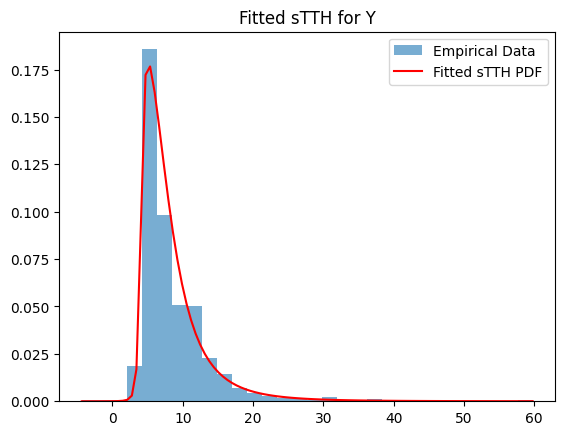

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from scipy.special import lambertw
from scipy.stats import t

# Simulate covariates
n = 1000
Z1 = np.random.uniform(0, 5, n)
Z2 = np.random.normal(0, 1, n)
Z3 = np.random.binomial(10, 0.5, n)
Z4 = np.random.binomial(1, 0.4, n)
Z5 = np.random.binomial(1, 0.5, n)
Z6 = np.random.binomial(1, 0.6, n)

# Lambert W function for transforming
def lambert_w(x):
    return lambertw(x).real

# PDF of the sSTH distribution
def ssth_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    w = np.exp(-0.5 * lambert_w(h * y_scaled**2))
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    return (2 / omega) * t_pdf * t_cdf * jacobian

# Simulate from the sSTH distribution using rejection sampling
def simulate_ssth(n, psi, omega, a, nu, h):
    samples = []
    c = 2.0  # Rejection constant (adjust for higher acceptance rate)
    proposal_dist = t(df=nu)

    while len(samples) < n:
        y_proposal = proposal_dist.rvs(size=1)
        pdf_proposal = proposal_dist.pdf(y_proposal)
        pdf_target = ssth_pdf(y_proposal, psi, omega, a, nu, h)
        if np.random.uniform(0, c * pdf_proposal) <= pdf_target:
            samples.append(y_proposal[0])

    return np.array(samples)

epsilon_1 = simulate_ssth(n, psi=5, omega=1, a= 4, nu=5, h=10)

# Simulate response variables
Y1 = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon_1

X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))
Y = np.column_stack((Y1))

import numpy as np
from scipy.stats import t
from scipy.special import lambertw

# PDF of the sTTH distribution
def sTTH_pdf(y, psi, omega, a, nu, h):
    y_scaled = (y - psi) / omega
    W0 = lambertw(h * y_scaled**2).real
    w = np.exp(-0.5 * W0)
    multiplier = np.sqrt((nu + 1) / (nu + (y_scaled * w)**2))
    t_pdf = t.pdf(y_scaled * w, df=nu)
    t_cdf = t.cdf(a * y_scaled * w * multiplier, df=nu + 1)
    jacobian = w / (h * y_scaled**2 + w**2)
    pdf = (2 / omega) * t_pdf * t_cdf * jacobian
    return pdf
def log_likelihood(params, y):
    psi, omega, a, nu, h = params
    # Ensure omega > 0 and nu > 0 for valid parameters
    if omega <= 0 or nu <= 0:
        return np.inf  # Return a large value to penalize invalid parameters

    # Calculate the log-likelihood
    pdf_values = sTTH_pdf(y, psi, omega, a, nu, h)
    # Avoid log(0) or negative likelihoods
    if np.any(pdf_values <= 0):
        return np.inf
    log_likelihood_value = -np.sum(np.log(pdf_values))
    return log_likelihood_value

from scipy.optimize import minimize

# Initial guess for parameters
initial_params = [1, 1, 1, 2, 0.1]  # psi, omega, a, nu, h

# Fit sTTH to Y1
result_Y1 = minimize(log_likelihood, initial_params, args=(Y1,), method='L-BFGS-B',
                     bounds=[(-np.inf, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf), (1e-3, np.inf)])

# Extract fitted parameters
params_Y1 = result_Y1.x

print("Fitted Parameters for Y1 (psi, omega, a, nu, h):", params_Y1)
# print("Fitted Parameters for Y2 (psi, omega, a, nu, h):", params_Y2)
import matplotlib.pyplot as plt

# Evaluate the fitted PDF for Y1
y_vals = np.linspace(min(Y1), max(Y1), 100)
fitted_pdf_Y1 = sTTH_pdf(y_vals, *params_Y1)

# Plot histogram and fitted PDF
plt.hist(Y1, bins=30, density=True, alpha=0.6, label='Empirical Data')
plt.plot(y_vals, fitted_pdf_Y1, label='Fitted sTTH PDF', color='red')
plt.title('Fitted sTTH for Y')
plt.legend()
plt.savefig("marginal_sTTH.pdf")

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

class CustomLoss(nn.Module):
    def __init__(self, nu, omega, a):
        """
        Custom loss function based on provided parameters
        :param nu: Degrees of freedom parameter
        :param omega: Scale parameter
        :param a: Shape parameter
        """
        super(CustomLoss, self).__init__()
        self.nu = nu
        self.omega = omega
        self.a = a

    def forward(self, predictions, targets):
        residuals = targets - predictions
        term1 = 1 + (residuals**2) / (self.nu * self.omega**2)
        term2 = 1 + torch.tensor(
            norm.cdf((self.a * residuals / self.omega).detach().numpy()), dtype=torch.float32
        )
        term3 = residuals**2
        loss = torch.sum(term1 * term2 * term3)
        return loss
class MSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MSNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Train and evaluate the model for a specific target (e.g., Y1 or Y2)
def train_and_evaluate_model(X_train, Y_train, X_calib, Y_calib, X_test, Y_test, nu, omega, a, epochs=500, lr=0.01, alpha=0.1):
    input_size = X_train.shape[1]
    output_size = Y_train.shape[1]
    hidden_size = 32

    # Initialize the model, loss, and optimizer
    msnn_model = MSNN(input_size, hidden_size, output_size)
    custom_loss_fn = CustomLoss(nu, omega, a)
    optimizer = torch.optim.Adam(msnn_model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_calib_tensor = torch.tensor(X_calib, dtype=torch.float32)
    Y_calib_tensor = torch.tensor(Y_calib, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    # Training loop
    for epoch in range(epochs):
        msnn_model.train()
        optimizer.zero_grad()
        predictions = msnn_model(X_train_tensor)
        loss = custom_loss_fn(predictions, Y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # --------------------------
    # 1. Compute Residuals on Calibration Set for Conformal Prediction
    # --------------------------
    msnn_model.eval()
    with torch.no_grad():
        Y_calib_pred = msnn_model(X_calib_tensor).numpy().flatten()

    # Compute absolute residuals (nonconformity scores)
    nonconformity_scores = np.abs(Y_calib.flatten() - Y_calib_pred)

    # --------------------------
    # 2. Compute Conformal Quantile Threshold
    # --------------------------
    q_hat = np.quantile(nonconformity_scores, (1 - alpha) * (len(Y_calib) + 1) / len(Y_calib))

    # --------------------------
    # 3. Compute Predictions and Conformal Bands for Test Data
    # --------------------------
    with torch.no_grad():
        Y_test_pred = msnn_model(X_test_tensor).numpy().flatten()

    # Construct conformal prediction intervals
    lower_bounds = Y_test_pred - q_hat
    upper_bounds = Y_test_pred + q_hat

    # --------------------------
    # 4. Evaluate Metrics
    # --------------------------
    train_predictions = msnn_model(X_train_tensor).detach().numpy()
    test_mse = np.mean((Y_test.flatten() - Y_test_pred) ** 2)
    train_mse = np.mean((Y_train.flatten() - train_predictions.flatten()) ** 2)

    # Empirical Coverage
    coverage = np.mean((Y_test.flatten() >= lower_bounds) & (Y_test.flatten() <= upper_bounds))
    print(f"Empirical Coverage: {coverage:.3f}")

    return train_mse, test_mse, Y_test_pred, lower_bounds, upper_bounds, coverage

# Example extracted parameters (replace with actual estimates from fitting)
omega_1, a_1, nu_1 = params_Y1[1],params_Y1[2],params_Y1[3]  # Parameters for Y1
# omega_2, a_2, nu_2 = params_Y2[1],params_Y2[2],params_Y2[3]  # Parameters for Y2
# Train model and obtain conformal prediction intervals
# Ensure Y is a 2D array
Y = Y.reshape(-1, 1)  # Reshape to (1000, 1)

# Split data into Train (60%), Calibration (20%), and Test (20%)
X_train_Y1, X_temp, Y_train_Y1, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_calib, X_test_Y1, Y_calib, Y_test_Y1 = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

train_mse, test_mse, Y_test_pred, lower_bounds, upper_bounds, coverage = train_and_evaluate_model(
    X_train_Y1, Y_train_Y1, X_calib, Y_calib, X_test_Y1, Y_test_Y1, nu_1, omega_1, a_1
)

# --------------------------
# 5. Display Results
# --------------------------
df_results = pd.DataFrame({
    'X1': X_test_Y1[:, 0], 'X2': X_test_Y1[:, 1],  # Display first 2 features
    'Y_true': Y_test_Y1.flatten(), 'Y_pred': Y_test_pred,
    'Lower_Bound': lower_bounds, 'Upper_Bound': upper_bounds
})

print(df_results.head())  # Display first few rows


print(f"Final Metrics -> Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, Coverage: {coverage:.3f}")



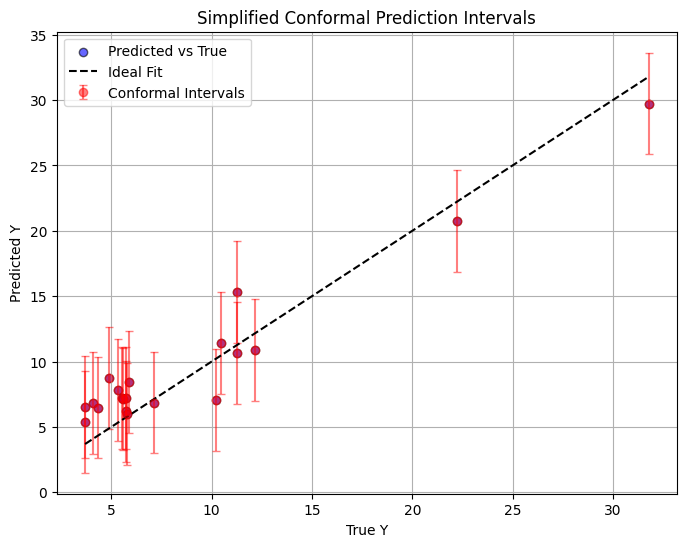

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# Reduce the number of points for better visualization
num_points = 20  # Select a smaller subset for clarity
indices_subset = np.random.choice(len(Y_test_Y1), num_points, replace=False)

Y_subset = Y_test_Y1.flatten()[indices_subset]
Y_pred_subset = Y_test_pred[indices_subset]
lower_subset = lower_bounds[indices_subset]
upper_subset = upper_bounds[indices_subset]

# Sort the subset for better visualization
sorted_indices = np.argsort(Y_subset)
Y_sorted = Y_subset[sorted_indices]
Y_pred_sorted = Y_pred_subset[sorted_indices]
lower_sorted = lower_subset[sorted_indices]
upper_sorted = upper_subset[sorted_indices]

plt.figure(figsize=(8, 6))

# Scatter plot for predicted vs true values
plt.scatter(Y_sorted, Y_pred_sorted, label="Predicted vs True", color="blue", alpha=0.6, edgecolor="k")

# Error bars instead of overlapping bands
plt.errorbar(Y_sorted, Y_pred_sorted, yerr=[Y_pred_sorted - lower_sorted, upper_sorted - Y_pred_sorted],
             fmt='o', color='red', alpha=0.5, label="Conformal Intervals", capsize=3)

# Ideal diagonal line (perfect predictions)
plt.plot(Y_sorted, Y_sorted, color="black", linestyle="dashed", label="Ideal Fit")

# Labels and Title
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("Simplified Conformal Prediction Intervals")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


Epoch 10/500, Loss: 30078.1172
Epoch 20/500, Loss: 13028.0850
Epoch 30/500, Loss: 11641.7910
Epoch 40/500, Loss: 7462.4502
Epoch 50/500, Loss: 6173.3960
Epoch 60/500, Loss: 5477.6567
Epoch 70/500, Loss: 4920.7080
Epoch 80/500, Loss: 4473.5361
Epoch 90/500, Loss: 4133.2231
Epoch 100/500, Loss: 3873.7476
Epoch 110/500, Loss: 3670.8972
Epoch 120/500, Loss: 3495.3518
Epoch 130/500, Loss: 3328.0632
Epoch 140/500, Loss: 3116.0437
Epoch 150/500, Loss: 2902.1648
Epoch 160/500, Loss: 2698.4211
Epoch 170/500, Loss: 2499.3459
Epoch 180/500, Loss: 2317.7439
Epoch 190/500, Loss: 2155.7883
Epoch 200/500, Loss: 2015.8265
Epoch 210/500, Loss: 1894.0941
Epoch 220/500, Loss: 1788.6492
Epoch 230/500, Loss: 1697.9025
Epoch 240/500, Loss: 1621.8000
Epoch 250/500, Loss: 1558.8628
Epoch 260/500, Loss: 1503.8070
Epoch 270/500, Loss: 1453.9186
Epoch 280/500, Loss: 1413.5944
Epoch 290/500, Loss: 1381.3251
Epoch 300/500, Loss: 1245.4189
Epoch 310/500, Loss: 1153.3729
Epoch 320/500, Loss: 1097.6116
Epoch 330/500,

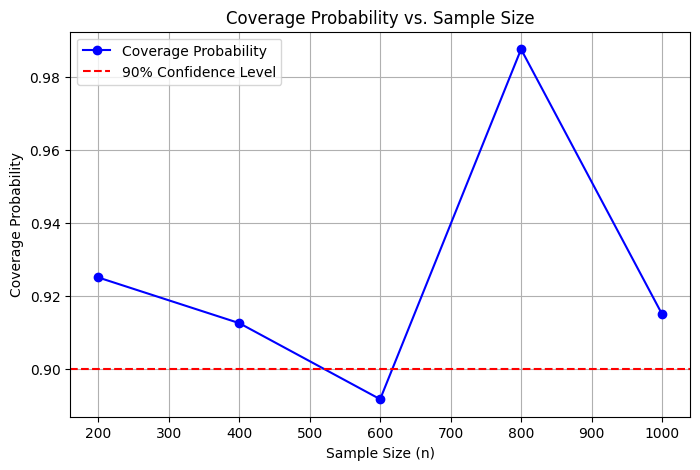

In [15]:
import matplotlib.pyplot as plt

# Define different sample sizes to test
sample_sizes = [200, 400, 600, 800, 1000]
coverage_results = []  # Store coverage probabilities

for n in sample_sizes:
    # Simulate covariates
    Z1 = np.random.uniform(0, 5, n)
    Z2 = np.random.normal(0, 1, n)
    Z3 = np.random.binomial(10, 0.5, n)
    Z4 = np.random.binomial(1, 0.4, n)
    Z5 = np.random.binomial(1, 0.5, n)
    Z6 = np.random.binomial(1, 0.6, n)

    X = np.column_stack((Z1, Z2, Z3, Z4, Z5, Z6))

    # Simulate Y using the sSTH distribution
    epsilon = simulate_ssth(n, psi=5, omega=1, a=4, nu=5, h=10)
    Y = Z1 * Z2**2 + Z3 * Z4 * Z5 * Z6 + epsilon
    Y = Y.reshape(-1, 1)  # Ensure Y is 2D

    # Split into Train (60%), Calibration (20%), and Test (20%)
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
    X_calib, X_test, Y_calib, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    # Train and evaluate model
    _, _, _, _, _, coverage = train_and_evaluate_model(
        X_train, Y_train, X_calib, Y_calib, X_test, Y_test, nu_1, omega_1, a_1
    )

    coverage_results.append(coverage)

# Plot Coverage Probability vs. Sample Size
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, coverage_results, marker='o', linestyle='-', color='b', label='Coverage Probability')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Confidence Level')  # Expected coverage level
plt.xlabel('Sample Size (n)')
plt.ylabel('Coverage Probability')
plt.title('Coverage Probability vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()
